# Training machine learning models on tabular data: an end-to-end example (non-Unity Catalog)

This tutorial covers the following steps:
- Visualize the data using Seaborn and matplotlib
- Run a parallel hyperparameter sweep to train multiple models
- Explore hyperparameter sweep results with MLflow
- Register the best performing model in MLflow
- Apply the registered model to another dataset using a Spark UDF

In this example, you build a model to predict the quality of Portuguese "Vinho Verde" wine based on the wine's physicochemical properties. 

The example uses a dataset from the UCI Machine Learning Repository, presented in [*Modeling wine preferences by data mining from physicochemical properties*](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub) [Cortez et al., 2009].

## Requirements
This notebook requires a cluster running Databricks Runtime 15.4 LTS ML or above.

If your workspace is enabled for Unity Catalog, do not use this notebook. A version for workspaces that are enabled for Unity Catalog is available: ([AWS](https://docs.databricks.com/mlflow/end-to-end-example.html) | [Azure](https://docs.microsoft.com/azure/databricks/mlflow/end-to-end-example) | [GCP](https://docs.gcp.databricks.com/mlflow/end-to-end-example.html)).

In [0]:
%pip install mlflow==2.5.0 scikit-learn==1.3.0 cloudpickle==2.2.1 numpy==1.25.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 79.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 kB 24.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Not uninstalling numpy at /databricks/python3/lib/python3.10/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstall: gunicorn
    Found existing installation: gunicorn 21.2.0
    Uninstalling gunicorn-21.2.0:
      Successfully uninstalled gunicorn-21.2.0
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 2.0.0
    Uninstalling cloudpick

In [0]:
%restart_python

## Read the data
Read the white wine quality and red wine quality CSV datasets and merge them into a single DataFrame.

In [0]:
import pandas as pd

white_wine = pd.read_csv("/databricks-datasets/wine-quality/winequality-white.csv", sep=";")
red_wine = pd.read_csv("/databricks-datasets/wine-quality/winequality-red.csv", sep=";")

Merge the two DataFrames into a single dataset, with a new binary feature "is_red" that indicates whether the wine is red or white.

In [0]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0

data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [0]:
data.head()

fixed_acidity  volatile_acidity  citric_acid  ...  alcohol  quality  is_red
0            7.4              0.70         0.00  ...      9.4        5       1
1            7.8              0.88         0.00  ...      9.8        5       1
2            7.8              0.76         0.04  ...      9.8        5       1
3           11.2              0.28         0.56  ...      9.8        6       1
4            7.4              0.70         0.00  ...      9.4        5       1

[5 rows x 13 columns]

## Visualize data

Before training a model, explore the dataset using Seaborn and Matplotlib.

Plot a histogram of the dependent variable, quality.

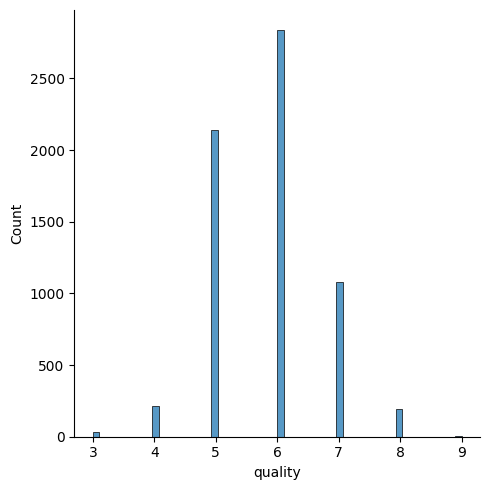

In [0]:
import seaborn as sns
sns.displot(data.quality, kde=False)

Looks like quality scores are normally distributed between 3 and 9. 

Define a wine as high quality if it has quality >= 7.

In [0]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

Box plots are useful for identifying correlations between features and a binary label. Create box plots for each feature to compare high-quality and low-quality wines. Significant differences in the box plots indicate good predictors of quality.

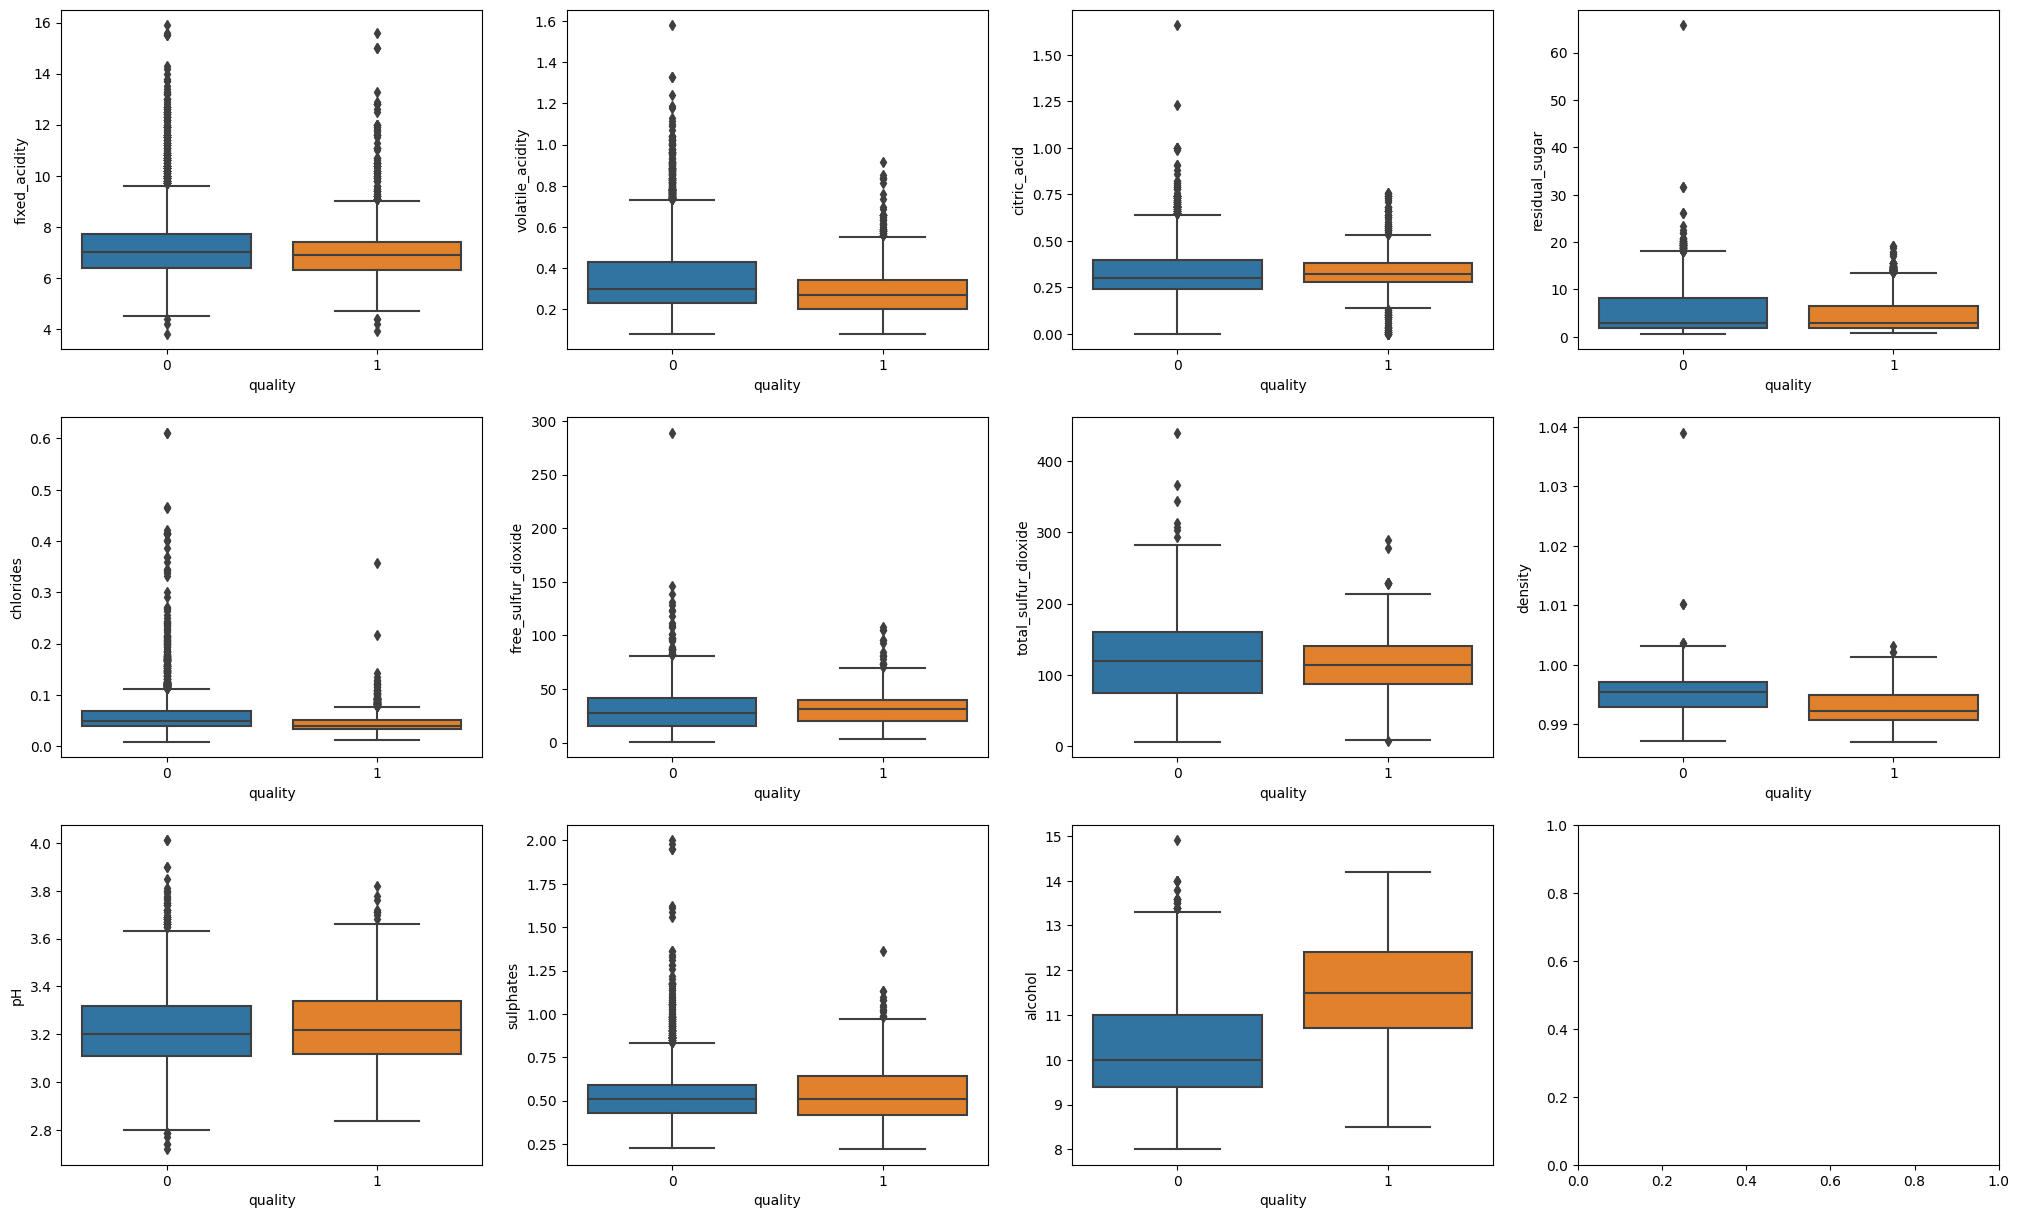

In [0]:
import matplotlib.pyplot as plt

dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

In the above box plots, a few variables stand out as good univariate predictors of quality. 

- In the alcohol box plot, the median alcohol content of high quality wines is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.
- In the density box plot, low quality wines have a greater density than high quality wines. Density is inversely correlated with quality.

## Preprocess data
Before training a model, check for missing values and split the data into training and validation sets.

In [0]:
data.isna().any()

fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
is_red                  False
dtype: bool

There are no missing values.

## Prepare the dataset to train a baseline model
Split the input data into 3 sets:
- Train (60% of the dataset used to train the model)
- Validation (20% of the dataset used to tune the hyperparameters)
- Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

In [0]:
from sklearn.model_selection import train_test_split

X = data.drop(["quality"], axis=1)
y = data.quality

# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)

# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

## Train a baseline model
This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

Build a simple classifier using scikit-learn and use MLflow to keep track of the model's accuracy, and to save the model for later use.

In [0]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time

# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)

  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning:

Review the learned feature importances output by the model. As illustrated by the previous boxplots, alcohol and density are important in predicting quality.

In [0]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

importance
alcohol                 0.160192
density                 0.117415
volatile_acidity        0.093136
chlorides               0.086618
residual_sugar          0.082544
free_sulfur_dioxide     0.080473
pH                      0.080212
total_sulfur_dioxide    0.077798
sulphates               0.075780
citric_acid             0.071857
fixed_acidity           0.071841
is_red                  0.002134

You logged the Area Under the ROC Curve (AUC) to MLflow. Click the Experiment icon <img src="https://docs.databricks.com/_static/images/icons/experiment.png"/> in the right sidebar to display the Experiment Runs sidebar. 

The model achieved an AUC of 0.854.

A random classifier would have an AUC of 0.5, and higher AUC values are better. For more information, see [Receiver Operating Characteristic Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

#### Register the model in MLflow Model Registry

By registering this model in Model Registry, you can easily reference the model from anywhere within Databricks.

The following section shows how to do this programmatically.

In [0]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id

In [0]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
model_name = "wine_quality"
model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Registered model 'wine_quality' already exists. Creating a new version of this model...
2024/10/22 21:22:10 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: wine_quality, version 9
Created version '9' of model 'wine_quality'.


You should now see the model in the Models page. To display the Models page, click **Models** in the left sidebar. 

Next, transition this model to production and load it into this notebook from Model Registry.

In [0]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

/root/.ipykernel/16399/command-3770961151225479-3087969861:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1729632129975, current_stage='Production', description='', last_updated_timestamp=1729632151747, name='wine_quality', run_id='a2cd9c3e31b640acb1ae742e2144a2f2', run_link='', source='dbfs:/databricks/mlflow-tracking/3770961151225450/a2cd9c3e31b640acb1ae742e2144a2f2/artifacts/random_forest_model', status='READY', status_message='', tags={}, user_id='4304861999953152', version='9'>

The Models page now shows the model version in stage "Production".

You can now refer to the model using the path "models:/wine_quality/production".

In [0]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")

# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

/databricks/python/lib/python3.11/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


AUC: 0.8540300975814177


##Experiment with a new model

The random forest model performed well even without hyperparameter tuning.

Use the xgboost library to train a more accurate model. Run a hyperparameter sweep to train multiple models in parallel, using Hyperopt and SparkTrials. As before, MLflow tracks the performance of each parameter configuration.

In [0]:
%pip install xgboost==1.7.6 hyperopt==0.2.7


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 99.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 98.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 80.3 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%restart_python

In [0]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb

search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, # Set a seed for deterministic training
}

def train_model(params):
  # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
  mlflow.xgboost.autolog()
  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    validation = xgb.DMatrix(data=X_val, label=y_val)
    # Pass in the validation set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
    # is no longer improving.
    booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                        evals=[(validation, "validation")], early_stopping_rounds=50)
    validation_predictions = booster.predict(validation)
    auc_score = roc_auc_score(y_val, validation_predictions)
    mlflow.log_metric('auc', auc_score)

    signature = infer_signature(X_train, booster.predict(train))
    mlflow.xgboost.log_model(booster, "model", signature=signature)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}

# Greater parallelism will lead to speedups, but a less optimal hyperparameter sweep. 
# A reasonable value for parallelism is the square root of max_evals.
spark_trials = Trials()

# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='xgboost_models'):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=96,
    trials=spark_trials,
  )

[0]	validation-logloss:0.45410
[1]	validation-logloss:0.39233
[2]	validation-logloss:0.37538
[3]	validation-logloss:0.36434
[4]	validation-logloss:0.36202
[5]	validation-logloss:0.36460
[6]	validation-logloss:0.36404
[7]	validation-logloss:0.36109
[8]	validation-logloss:0.36316
[9]	validation-logloss:0.36557
[10]	validation-logloss:0.36656
[11]	validation-logloss:0.37194
[12]	validation-logloss:0.37101
[13]	validation-logloss:0.37127
[14]	validation-logloss:0.36953
[15]	validation-logloss:0.36591
[16]	validation-logloss:0.37380
[17]	validation-logloss:0.37649
[18]	validation-logloss:0.37710
[19]	validation-logloss:0.37515
[20]	validation-logloss:0.37754
[21]	validation-logloss:0.38055
[22]	validation-logloss:0.38057
[23]	validation-logloss:0.37481
[24]	validation-logloss:0.37501
[25]	validation-logloss:0.37683
[26]	validation-logloss:0.37673
[27]	validation-logloss:0.37556
[28]	validation-logloss:0.38017
[29]	validation-logloss:0.38034
[30]	validation-logloss:0.38062
[31]	validation-lo

2025/03/22 12:03:53 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/py

[0]	validation-logloss:0.49082
[1]	validation-logloss:0.41339
[2]	validation-logloss:0.37409
[3]	validation-logloss:0.35445
[4]	validation-logloss:0.34324
[5]	validation-logloss:0.33997
[6]	validation-logloss:0.33847
[7]	validation-logloss:0.33935
[8]	validation-logloss:0.34253
[9]	validation-logloss:0.34748
[10]	validation-logloss:0.34572
[11]	validation-logloss:0.34726
[12]	validation-logloss:0.34812
[13]	validation-logloss:0.34816
[14]	validation-logloss:0.34923
[15]	validation-logloss:0.35183
[16]	validation-logloss:0.35550
[17]	validation-logloss:0.35919
[18]	validation-logloss:0.36188
[19]	validation-logloss:0.36734
[20]	validation-logloss:0.36778
[21]	validation-logloss:0.36721
[22]	validation-logloss:0.37051
[23]	validation-logloss:0.37442
[24]	validation-logloss:0.37729
[25]	validation-logloss:0.37990
[26]	validation-logloss:0.38052
[27]	validation-logloss:0.38070
[28]	validation-logloss:0.38360
[29]	validation-logloss:0.38440
[30]	validation-logloss:0.38373
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.45228
[1]	validation-logloss:0.38977
[2]	validation-logloss:0.36634
[3]	validation-logloss:0.36010
[4]	validation-logloss:0.35268
[5]	validation-logloss:0.35551
[6]	validation-logloss:0.36508
[7]	validation-logloss:0.36038
[8]	validation-logloss:0.35750
[9]	validation-logloss:0.35745
[10]	validation-logloss:0.36021
[11]	validation-logloss:0.36096
[12]	validation-logloss:0.36247
[13]	validation-logloss:0.36111
[14]	validation-logloss:0.36512
[15]	validation-logloss:0.36196
[16]	validation-logloss:0.36184
[17]	validation-logloss:0.36055
[18]	validation-logloss:0.36011
[19]	validation-logloss:0.36059
[20]	validation-logloss:0.35939
[21]	validation-logloss:0.35758
[22]	validation-logloss:0.35406
[23]	validation-logloss:0.35485
[24]	validation-logloss:0.35652
[25]	validation-logloss:0.35660
[26]	validation-logloss:0.35750
[27]	validation-logloss:0.35466
[28]	validation-logloss:0.35893
[29]	validation-logloss:0.36217
[30]	validation-logloss:0.36586
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.64330
[1]	validation-logloss:0.60263
[2]	validation-logloss:0.56727
[3]	validation-logloss:0.53994
[4]	validation-logloss:0.51554
[5]	validation-logloss:0.49362
[6]	validation-logloss:0.47688
[7]	validation-logloss:0.45968
[8]	validation-logloss:0.44481
[9]	validation-logloss:0.43218
[10]	validation-logloss:0.42141
[11]	validation-logloss:0.41120
[12]	validation-logloss:0.40320
[13]	validation-logloss:0.39558
[14]	validation-logloss:0.38935
[15]	validation-logloss:0.38339
[16]	validation-logloss:0.37732
[17]	validation-logloss:0.37156
[18]	validation-logloss:0.36707
[19]	validation-logloss:0.36310
[20]	validation-logloss:0.35866
[21]	validation-logloss:0.35605
[22]	validation-logloss:0.35344
[23]	validation-logloss:0.35020
[24]	validation-logloss:0.34681
[25]	validation-logloss:0.34392
[26]	validation-logloss:0.34156
[27]	validation-logloss:0.33948
[28]	validation-logloss:0.33845
[29]	validation-logloss:0.33581
[30]	validation-logloss:0.33490
[31]	validation-lo

2025/03/22 12:04:21 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/py

[0]	validation-logloss:0.65509
[1]	validation-logloss:0.62240
[2]	validation-logloss:0.59301
[3]	validation-logloss:0.56789
[4]	validation-logloss:0.54450
[5]	validation-logloss:0.52467
[6]	validation-logloss:0.50686
[7]	validation-logloss:0.49152
[8]	validation-logloss:0.47650
[9]	validation-logloss:0.46341
[10]	validation-logloss:0.45170
[11]	validation-logloss:0.44116
[12]	validation-logloss:0.43159
[13]	validation-logloss:0.42288
[14]	validation-logloss:0.41370
[15]	validation-logloss:0.40578
[16]	validation-logloss:0.39845
[17]	validation-logloss:0.39152
[18]	validation-logloss:0.38543
[19]	validation-logloss:0.38076
[20]	validation-logloss:0.37609
[21]	validation-logloss:0.37276
[22]	validation-logloss:0.36862
[23]	validation-logloss:0.36438
[24]	validation-logloss:0.36108
[25]	validation-logloss:0.35825
[26]	validation-logloss:0.35546
[27]	validation-logloss:0.35311
[28]	validation-logloss:0.35065
[29]	validation-logloss:0.34765
[30]	validation-logloss:0.34549
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.56571
[1]	validation-logloss:0.48843
[2]	validation-logloss:0.44290
[3]	validation-logloss:0.41054
[4]	validation-logloss:0.38620
[5]	validation-logloss:0.37254
[6]	validation-logloss:0.36385
[7]	validation-logloss:0.35730
[8]	validation-logloss:0.34993
[9]	validation-logloss:0.34651
[10]	validation-logloss:0.34338
[11]	validation-logloss:0.33536
[12]	validation-logloss:0.33303
[13]	validation-logloss:0.33193
[14]	validation-logloss:0.32900
[15]	validation-logloss:0.32744
[16]	validation-logloss:0.32674
[17]	validation-logloss:0.32816
[18]	validation-logloss:0.32620
[19]	validation-logloss:0.32448
[20]	validation-logloss:0.32522
[21]	validation-logloss:0.32242
[22]	validation-logloss:0.32003
[23]	validation-logloss:0.31986
[24]	validation-logloss:0.31940
[25]	validation-logloss:0.31883
[26]	validation-logloss:0.31924
[27]	validation-logloss:0.31860
[28]	validation-logloss:0.31857
[29]	validation-logloss:0.32013
[30]	validation-logloss:0.32043
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.65711
[1]	validation-logloss:0.62593
[2]	validation-logloss:0.59915
[3]	validation-logloss:0.57426
[4]	validation-logloss:0.55222
[5]	validation-logloss:0.53300
[6]	validation-logloss:0.51551
[7]	validation-logloss:0.50013
[8]	validation-logloss:0.48611
[9]	validation-logloss:0.47336
[10]	validation-logloss:0.46173
[11]	validation-logloss:0.45139
[12]	validation-logloss:0.44163
[13]	validation-logloss:0.43284
[14]	validation-logloss:0.42501
[15]	validation-logloss:0.41821
[16]	validation-logloss:0.41131
[17]	validation-logloss:0.40550
[18]	validation-logloss:0.40004
[19]	validation-logloss:0.39463
[20]	validation-logloss:0.38942
[21]	validation-logloss:0.38528
[22]	validation-logloss:0.38074
[23]	validation-logloss:0.37761
[24]	validation-logloss:0.37416
[25]	validation-logloss:0.37143
[26]	validation-logloss:0.36861
[27]	validation-logloss:0.36626
[28]	validation-logloss:0.36401
[29]	validation-logloss:0.36157
[30]	validation-logloss:0.35894
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.61942
[1]	validation-logloss:0.56488
[2]	validation-logloss:0.52391
[3]	validation-logloss:0.49071
[4]	validation-logloss:0.46422
[5]	validation-logloss:0.44232
[6]	validation-logloss:0.42492
[7]	validation-logloss:0.41125
[8]	validation-logloss:0.39833
[9]	validation-logloss:0.38878
[10]	validation-logloss:0.38052
[11]	validation-logloss:0.37164
[12]	validation-logloss:0.36640
[13]	validation-logloss:0.36043
[14]	validation-logloss:0.35627
[15]	validation-logloss:0.35327
[16]	validation-logloss:0.34979
[17]	validation-logloss:0.34797
[18]	validation-logloss:0.34562
[19]	validation-logloss:0.34387
[20]	validation-logloss:0.34081
[21]	validation-logloss:0.33959
[22]	validation-logloss:0.33838
[23]	validation-logloss:0.33686
[24]	validation-logloss:0.33609
[25]	validation-logloss:0.33528
[26]	validation-logloss:0.33343
[27]	validation-logloss:0.33311
[28]	validation-logloss:0.33172
[29]	validation-logloss:0.33036
[30]	validation-logloss:0.32952
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.63359
[1]	validation-logloss:0.58622
[2]	validation-logloss:0.54801
[3]	validation-logloss:0.51652
[4]	validation-logloss:0.49042
[5]	validation-logloss:0.46766
[6]	validation-logloss:0.44911
[7]	validation-logloss:0.43290
[8]	validation-logloss:0.41891
[9]	validation-logloss:0.40582
[10]	validation-logloss:0.39666
[11]	validation-logloss:0.38785
[12]	validation-logloss:0.37945
[13]	validation-logloss:0.37322
[14]	validation-logloss:0.36688
[15]	validation-logloss:0.36135
[16]	validation-logloss:0.35693
[17]	validation-logloss:0.35417
[18]	validation-logloss:0.35020
[19]	validation-logloss:0.34702
[20]	validation-logloss:0.34467
[21]	validation-logloss:0.34212
[22]	validation-logloss:0.34008
[23]	validation-logloss:0.33831
[24]	validation-logloss:0.33704
[25]	validation-logloss:0.33540
[26]	validation-logloss:0.33369
[27]	validation-logloss:0.33171
[28]	validation-logloss:0.32947
[29]	validation-logloss:0.32752
[30]	validation-logloss:0.32763
[31]	validation-lo

2025/03/22 12:05:13 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/py

[0]	validation-logloss:0.62045
[1]	validation-logloss:0.56494
[2]	validation-logloss:0.52057
[3]	validation-logloss:0.48774
[4]	validation-logloss:0.46038
[5]	validation-logloss:0.43565
[6]	validation-logloss:0.41617
[7]	validation-logloss:0.39948
[8]	validation-logloss:0.38701
[9]	validation-logloss:0.37711
[10]	validation-logloss:0.36811
[11]	validation-logloss:0.36186
[12]	validation-logloss:0.35465
[13]	validation-logloss:0.34903
[14]	validation-logloss:0.34448
[15]	validation-logloss:0.34042
[16]	validation-logloss:0.33487
[17]	validation-logloss:0.33206
[18]	validation-logloss:0.33023
[19]	validation-logloss:0.32751
[20]	validation-logloss:0.32528
[21]	validation-logloss:0.32311
[22]	validation-logloss:0.32119
[23]	validation-logloss:0.31952
[24]	validation-logloss:0.31792
[25]	validation-logloss:0.31776
[26]	validation-logloss:0.31782
[27]	validation-logloss:0.31702
[28]	validation-logloss:0.31662
[29]	validation-logloss:0.31636
[30]	validation-logloss:0.31529
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.64291
[1]	validation-logloss:0.60241
[2]	validation-logloss:0.56811
[3]	validation-logloss:0.53811
[4]	validation-logloss:0.51319
[5]	validation-logloss:0.49111
[6]	validation-logloss:0.47249
[7]	validation-logloss:0.45386
[8]	validation-logloss:0.43754
[9]	validation-logloss:0.42328
[10]	validation-logloss:0.41045
[11]	validation-logloss:0.40017
[12]	validation-logloss:0.39051
[13]	validation-logloss:0.38190
[14]	validation-logloss:0.37382
[15]	validation-logloss:0.36689
[16]	validation-logloss:0.36094
[17]	validation-logloss:0.35547
[18]	validation-logloss:0.34992
[19]	validation-logloss:0.34478
[20]	validation-logloss:0.34158
[21]	validation-logloss:0.33811
[22]	validation-logloss:0.33528
[23]	validation-logloss:0.33207
[24]	validation-logloss:0.32926
[25]	validation-logloss:0.32846
[26]	validation-logloss:0.32758
[27]	validation-logloss:0.32635
[28]	validation-logloss:0.32534
[29]	validation-logloss:0.32418
[30]	validation-logloss:0.32396
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.65762
[1]	validation-logloss:0.62672
[2]	validation-logloss:0.59858
[3]	validation-logloss:0.57449
[4]	validation-logloss:0.55196
[5]	validation-logloss:0.53376
[6]	validation-logloss:0.51627
[7]	validation-logloss:0.50102
[8]	validation-logloss:0.48705
[9]	validation-logloss:0.47370
[10]	validation-logloss:0.46216
[11]	validation-logloss:0.45154
[12]	validation-logloss:0.44160
[13]	validation-logloss:0.43210
[14]	validation-logloss:0.42388
[15]	validation-logloss:0.41657
[16]	validation-logloss:0.40925
[17]	validation-logloss:0.40247
[18]	validation-logloss:0.39676
[19]	validation-logloss:0.39145
[20]	validation-logloss:0.38614
[21]	validation-logloss:0.38119
[22]	validation-logloss:0.37672
[23]	validation-logloss:0.37234
[24]	validation-logloss:0.36832
[25]	validation-logloss:0.36541
[26]	validation-logloss:0.36226
[27]	validation-logloss:0.35919
[28]	validation-logloss:0.35681
[29]	validation-logloss:0.35435
[30]	validation-logloss:0.35249
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.64889
[1]	validation-logloss:0.61309
[2]	validation-logloss:0.58110
[3]	validation-logloss:0.55314
[4]	validation-logloss:0.52979
[5]	validation-logloss:0.50746
[6]	validation-logloss:0.48892
[7]	validation-logloss:0.47250
[8]	validation-logloss:0.45839
[9]	validation-logloss:0.44418
[10]	validation-logloss:0.43358
[11]	validation-logloss:0.42413
[12]	validation-logloss:0.41425
[13]	validation-logloss:0.40656
[14]	validation-logloss:0.39929
[15]	validation-logloss:0.39071
[16]	validation-logloss:0.38430
[17]	validation-logloss:0.37693
[18]	validation-logloss:0.37161
[19]	validation-logloss:0.36725
[20]	validation-logloss:0.36223
[21]	validation-logloss:0.35891
[22]	validation-logloss:0.35502
[23]	validation-logloss:0.35204
[24]	validation-logloss:0.34915
[25]	validation-logloss:0.34643
[26]	validation-logloss:0.34443
[27]	validation-logloss:0.34292
[28]	validation-logloss:0.34092
[29]	validation-logloss:0.33981
[30]	validation-logloss:0.33895
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.66588
[1]	validation-logloss:0.64142
[2]	validation-logloss:0.61924
[3]	validation-logloss:0.59943
[4]	validation-logloss:0.58089
[5]	validation-logloss:0.56431
[6]	validation-logloss:0.54892
[7]	validation-logloss:0.53515
[8]	validation-logloss:0.52227
[9]	validation-logloss:0.51052
[10]	validation-logloss:0.49982
[11]	validation-logloss:0.48944
[12]	validation-logloss:0.47981
[13]	validation-logloss:0.47129
[14]	validation-logloss:0.46335
[15]	validation-logloss:0.45561
[16]	validation-logloss:0.44869
[17]	validation-logloss:0.44244
[18]	validation-logloss:0.43674
[19]	validation-logloss:0.43107
[20]	validation-logloss:0.42608
[21]	validation-logloss:0.42149
[22]	validation-logloss:0.41709
[23]	validation-logloss:0.41317
[24]	validation-logloss:0.40913
[25]	validation-logloss:0.40503
[26]	validation-logloss:0.40159
[27]	validation-logloss:0.39813
[28]	validation-logloss:0.39541
[29]	validation-logloss:0.39284
[30]	validation-logloss:0.39020
[31]	validation-lo

2025/03/22 12:06:07 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/py

[0]	validation-logloss:0.52451
[1]	validation-logloss:0.44409
[2]	validation-logloss:0.39947
[3]	validation-logloss:0.37832
[4]	validation-logloss:0.36011
[5]	validation-logloss:0.34580
[6]	validation-logloss:0.34188
[7]	validation-logloss:0.34400
[8]	validation-logloss:0.33948
[9]	validation-logloss:0.33523
[10]	validation-logloss:0.33108
[11]	validation-logloss:0.33405
[12]	validation-logloss:0.33574
[13]	validation-logloss:0.33413
[14]	validation-logloss:0.33677
[15]	validation-logloss:0.33341
[16]	validation-logloss:0.33150
[17]	validation-logloss:0.33280
[18]	validation-logloss:0.33210
[19]	validation-logloss:0.33102
[20]	validation-logloss:0.33085
[21]	validation-logloss:0.33010
[22]	validation-logloss:0.33018
[23]	validation-logloss:0.32871
[24]	validation-logloss:0.32995
[25]	validation-logloss:0.32847
[26]	validation-logloss:0.33020
[27]	validation-logloss:0.33132
[28]	validation-logloss:0.33110
[29]	validation-logloss:0.32997
[30]	validation-logloss:0.32992
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.65489
[1]	validation-logloss:0.62190
[2]	validation-logloss:0.59343
[3]	validation-logloss:0.56820
[4]	validation-logloss:0.54650
[5]	validation-logloss:0.52704
[6]	validation-logloss:0.50981
[7]	validation-logloss:0.49434
[8]	validation-logloss:0.48051
[9]	validation-logloss:0.46785
[10]	validation-logloss:0.45709
[11]	validation-logloss:0.44701
[12]	validation-logloss:0.43858
[13]	validation-logloss:0.43024
[14]	validation-logloss:0.42350
[15]	validation-logloss:0.41723
[16]	validation-logloss:0.41099
[17]	validation-logloss:0.40614
[18]	validation-logloss:0.40127
[19]	validation-logloss:0.39656
[20]	validation-logloss:0.39232
[21]	validation-logloss:0.38864
[22]	validation-logloss:0.38527
[23]	validation-logloss:0.38222
[24]	validation-logloss:0.37918
[25]	validation-logloss:0.37644
[26]	validation-logloss:0.37414
[27]	validation-logloss:0.37211
[28]	validation-logloss:0.37020
[29]	validation-logloss:0.36846
[30]	validation-logloss:0.36657
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.61306
[1]	validation-logloss:0.55537
[2]	validation-logloss:0.51262
[3]	validation-logloss:0.47825
[4]	validation-logloss:0.45107
[5]	validation-logloss:0.42959
[6]	validation-logloss:0.41244
[7]	validation-logloss:0.39850
[8]	validation-logloss:0.38679
[9]	validation-logloss:0.37591
[10]	validation-logloss:0.36838
[11]	validation-logloss:0.36327
[12]	validation-logloss:0.35673
[13]	validation-logloss:0.35113
[14]	validation-logloss:0.34620
[15]	validation-logloss:0.34392
[16]	validation-logloss:0.34105
[17]	validation-logloss:0.33967
[18]	validation-logloss:0.33743
[19]	validation-logloss:0.33420
[20]	validation-logloss:0.33316
[21]	validation-logloss:0.33101
[22]	validation-logloss:0.32959
[23]	validation-logloss:0.32889
[24]	validation-logloss:0.32858
[25]	validation-logloss:0.32904
[26]	validation-logloss:0.32785
[27]	validation-logloss:0.32699
[28]	validation-logloss:0.32586
[29]	validation-logloss:0.32471
[30]	validation-logloss:0.32347
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.63012
[1]	validation-logloss:0.58225
[2]	validation-logloss:0.54145
[3]	validation-logloss:0.50804
[4]	validation-logloss:0.48235
[5]	validation-logloss:0.46046
[6]	validation-logloss:0.44179
[7]	validation-logloss:0.42583
[8]	validation-logloss:0.41287
[9]	validation-logloss:0.40197
[10]	validation-logloss:0.39209
[11]	validation-logloss:0.38316
[12]	validation-logloss:0.37539
[13]	validation-logloss:0.36976
[14]	validation-logloss:0.36476
[15]	validation-logloss:0.36060
[16]	validation-logloss:0.35602
[17]	validation-logloss:0.35156
[18]	validation-logloss:0.34830
[19]	validation-logloss:0.34585
[20]	validation-logloss:0.34380
[21]	validation-logloss:0.34254
[22]	validation-logloss:0.34048
[23]	validation-logloss:0.33944
[24]	validation-logloss:0.33817
[25]	validation-logloss:0.33802
[26]	validation-logloss:0.33653
[27]	validation-logloss:0.33571
[28]	validation-logloss:0.33421
[29]	validation-logloss:0.33279
[30]	validation-logloss:0.33188
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.51429
[1]	validation-logloss:0.43443
[2]	validation-logloss:0.39173
[3]	validation-logloss:0.37130
[4]	validation-logloss:0.35673
[5]	validation-logloss:0.34921
[6]	validation-logloss:0.34827
[7]	validation-logloss:0.34418
[8]	validation-logloss:0.34319
[9]	validation-logloss:0.34266
[10]	validation-logloss:0.34068
[11]	validation-logloss:0.34013
[12]	validation-logloss:0.33700
[13]	validation-logloss:0.33631
[14]	validation-logloss:0.33607
[15]	validation-logloss:0.33426
[16]	validation-logloss:0.33339
[17]	validation-logloss:0.33378
[18]	validation-logloss:0.33587
[19]	validation-logloss:0.33531
[20]	validation-logloss:0.33135
[21]	validation-logloss:0.33209
[22]	validation-logloss:0.33170
[23]	validation-logloss:0.33200
[24]	validation-logloss:0.33280
[25]	validation-logloss:0.32878
[26]	validation-logloss:0.32739
[27]	validation-logloss:0.32800
[28]	validation-logloss:0.32869
[29]	validation-logloss:0.32799
[30]	validation-logloss:0.32770
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.63564
[1]	validation-logloss:0.58998
[2]	validation-logloss:0.55325
[3]	validation-logloss:0.52299
[4]	validation-logloss:0.49779
[5]	validation-logloss:0.47702
[6]	validation-logloss:0.45907
[7]	validation-logloss:0.44377
[8]	validation-logloss:0.43189
[9]	validation-logloss:0.42025
[10]	validation-logloss:0.41121
[11]	validation-logloss:0.40323
[12]	validation-logloss:0.39566
[13]	validation-logloss:0.39024
[14]	validation-logloss:0.38530
[15]	validation-logloss:0.38081
[16]	validation-logloss:0.37593
[17]	validation-logloss:0.37303
[18]	validation-logloss:0.36926
[19]	validation-logloss:0.36631
[20]	validation-logloss:0.36432
[21]	validation-logloss:0.36238
[22]	validation-logloss:0.36052
[23]	validation-logloss:0.35791
[24]	validation-logloss:0.35525
[25]	validation-logloss:0.35360
[26]	validation-logloss:0.35230
[27]	validation-logloss:0.35110
[28]	validation-logloss:0.34977
[29]	validation-logloss:0.34878
[30]	validation-logloss:0.34774
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.58646
[1]	validation-logloss:0.51680
[2]	validation-logloss:0.46676
[3]	validation-logloss:0.43024
[4]	validation-logloss:0.39868
[5]	validation-logloss:0.37729
[6]	validation-logloss:0.36028
[7]	validation-logloss:0.34692
[8]	validation-logloss:0.33937
[9]	validation-logloss:0.33261
[10]	validation-logloss:0.32662
[11]	validation-logloss:0.32465
[12]	validation-logloss:0.32248
[13]	validation-logloss:0.32121
[14]	validation-logloss:0.31890
[15]	validation-logloss:0.31761
[16]	validation-logloss:0.31725
[17]	validation-logloss:0.31822
[18]	validation-logloss:0.31796
[19]	validation-logloss:0.31794
[20]	validation-logloss:0.31879
[21]	validation-logloss:0.31882
[22]	validation-logloss:0.31996
[23]	validation-logloss:0.32024
[24]	validation-logloss:0.32038
[25]	validation-logloss:0.32189
[26]	validation-logloss:0.32466
[27]	validation-logloss:0.32411
[28]	validation-logloss:0.32434
[29]	validation-logloss:0.32561
[30]	validation-logloss:0.32687
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.57817
[1]	validation-logloss:0.50945
[2]	validation-logloss:0.46431
[3]	validation-logloss:0.42973
[4]	validation-logloss:0.40766
[5]	validation-logloss:0.38607
[6]	validation-logloss:0.36833
[7]	validation-logloss:0.35588
[8]	validation-logloss:0.34824
[9]	validation-logloss:0.34406
[10]	validation-logloss:0.33990
[11]	validation-logloss:0.33803
[12]	validation-logloss:0.33842
[13]	validation-logloss:0.33907
[14]	validation-logloss:0.34032
[15]	validation-logloss:0.33972
[16]	validation-logloss:0.34118
[17]	validation-logloss:0.34149
[18]	validation-logloss:0.34141
[19]	validation-logloss:0.34393
[20]	validation-logloss:0.34508
[21]	validation-logloss:0.34816
[22]	validation-logloss:0.35128
[23]	validation-logloss:0.35154
[24]	validation-logloss:0.34912
[25]	validation-logloss:0.34937
[26]	validation-logloss:0.35123
[27]	validation-logloss:0.35434
[28]	validation-logloss:0.35542
[29]	validation-logloss:0.35668
[30]	validation-logloss:0.35976
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.57306
[1]	validation-logloss:0.49993
[2]	validation-logloss:0.45384
[3]	validation-logloss:0.42399
[4]	validation-logloss:0.40235
[5]	validation-logloss:0.38409
[6]	validation-logloss:0.36777
[7]	validation-logloss:0.35701
[8]	validation-logloss:0.34854
[9]	validation-logloss:0.34576
[10]	validation-logloss:0.34322
[11]	validation-logloss:0.34292
[12]	validation-logloss:0.34250
[13]	validation-logloss:0.34230
[14]	validation-logloss:0.34524
[15]	validation-logloss:0.34729
[16]	validation-logloss:0.34975
[17]	validation-logloss:0.35094
[18]	validation-logloss:0.35260
[19]	validation-logloss:0.35421
[20]	validation-logloss:0.35801
[21]	validation-logloss:0.35939
[22]	validation-logloss:0.36207
[23]	validation-logloss:0.36438
[24]	validation-logloss:0.36534
[25]	validation-logloss:0.36653
[26]	validation-logloss:0.36950
[27]	validation-logloss:0.37216
[28]	validation-logloss:0.37426
[29]	validation-logloss:0.37577
[30]	validation-logloss:0.37669
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.55889
[1]	validation-logloss:0.48338
[2]	validation-logloss:0.43752
[3]	validation-logloss:0.40801
[4]	validation-logloss:0.38140
[5]	validation-logloss:0.36343
[6]	validation-logloss:0.35421
[7]	validation-logloss:0.34622
[8]	validation-logloss:0.34128
[9]	validation-logloss:0.33729
[10]	validation-logloss:0.33715
[11]	validation-logloss:0.33671
[12]	validation-logloss:0.33865
[13]	validation-logloss:0.33829
[14]	validation-logloss:0.33938
[15]	validation-logloss:0.34249
[16]	validation-logloss:0.34362
[17]	validation-logloss:0.34531
[18]	validation-logloss:0.34882
[19]	validation-logloss:0.35021
[20]	validation-logloss:0.35246
[21]	validation-logloss:0.35631
[22]	validation-logloss:0.36051
[23]	validation-logloss:0.36175
[24]	validation-logloss:0.36378
[25]	validation-logloss:0.36640
[26]	validation-logloss:0.36729
[27]	validation-logloss:0.36940
[28]	validation-logloss:0.37122
[29]	validation-logloss:0.37134
[30]	validation-logloss:0.37281
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.54486
[1]	validation-logloss:0.46770
[2]	validation-logloss:0.41846
[3]	validation-logloss:0.38847
[4]	validation-logloss:0.36542
[5]	validation-logloss:0.35075
[6]	validation-logloss:0.34306
[7]	validation-logloss:0.34096
[8]	validation-logloss:0.33832
[9]	validation-logloss:0.33660
[10]	validation-logloss:0.33726
[11]	validation-logloss:0.34041
[12]	validation-logloss:0.33918
[13]	validation-logloss:0.33836
[14]	validation-logloss:0.34054
[15]	validation-logloss:0.34153
[16]	validation-logloss:0.34216
[17]	validation-logloss:0.34749
[18]	validation-logloss:0.34889
[19]	validation-logloss:0.35028
[20]	validation-logloss:0.35342
[21]	validation-logloss:0.35255
[22]	validation-logloss:0.35319
[23]	validation-logloss:0.35385
[24]	validation-logloss:0.35554
[25]	validation-logloss:0.35724
[26]	validation-logloss:0.35937
[27]	validation-logloss:0.36194
[28]	validation-logloss:0.36365
[29]	validation-logloss:0.36670
[30]	validation-logloss:0.37002
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.45215
[1]	validation-logloss:0.43644
[2]	validation-logloss:0.41465
[3]	validation-logloss:0.41904
[4]	validation-logloss:0.42781
[5]	validation-logloss:0.43403
[6]	validation-logloss:0.43673
[7]	validation-logloss:0.44575
[8]	validation-logloss:0.44708
[9]	validation-logloss:0.45092
[10]	validation-logloss:0.45753
[11]	validation-logloss:0.45637
[12]	validation-logloss:0.45843
[13]	validation-logloss:0.46328
[14]	validation-logloss:0.46643
[15]	validation-logloss:0.47048
[16]	validation-logloss:0.47596
[17]	validation-logloss:0.47718
[18]	validation-logloss:0.47904
[19]	validation-logloss:0.47961
[20]	validation-logloss:0.47714
[21]	validation-logloss:0.48532
[22]	validation-logloss:0.48800
[23]	validation-logloss:0.49135
[24]	validation-logloss:0.49276
[25]	validation-logloss:0.49527
[26]	validation-logloss:0.50053
[27]	validation-logloss:0.50134
[28]	validation-logloss:0.49698
[29]	validation-logloss:0.49932
[30]	validation-logloss:0.50271
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.58387
[1]	validation-logloss:0.51308
[2]	validation-logloss:0.46387
[3]	validation-logloss:0.42819
[4]	validation-logloss:0.40019
[5]	validation-logloss:0.37727
[6]	validation-logloss:0.36246
[7]	validation-logloss:0.34871
[8]	validation-logloss:0.33988
[9]	validation-logloss:0.33283
[10]	validation-logloss:0.32858
[11]	validation-logloss:0.32691
[12]	validation-logloss:0.32338
[13]	validation-logloss:0.32266
[14]	validation-logloss:0.32012
[15]	validation-logloss:0.32021
[16]	validation-logloss:0.32041
[17]	validation-logloss:0.32078
[18]	validation-logloss:0.32243
[19]	validation-logloss:0.32303
[20]	validation-logloss:0.32456
[21]	validation-logloss:0.32632
[22]	validation-logloss:0.32920
[23]	validation-logloss:0.32978
[24]	validation-logloss:0.33188
[25]	validation-logloss:0.33372
[26]	validation-logloss:0.33295
[27]	validation-logloss:0.33506
[28]	validation-logloss:0.33719
[29]	validation-logloss:0.33906
[30]	validation-logloss:0.33998
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.59576
[1]	validation-logloss:0.52818
[2]	validation-logloss:0.48297
[3]	validation-logloss:0.44593
[4]	validation-logloss:0.41555
[5]	validation-logloss:0.39255
[6]	validation-logloss:0.37303
[7]	validation-logloss:0.35922
[8]	validation-logloss:0.34575
[9]	validation-logloss:0.33561
[10]	validation-logloss:0.33028
[11]	validation-logloss:0.32503
[12]	validation-logloss:0.32100
[13]	validation-logloss:0.31900
[14]	validation-logloss:0.31783
[15]	validation-logloss:0.31749
[16]	validation-logloss:0.31752
[17]	validation-logloss:0.31672
[18]	validation-logloss:0.31607
[19]	validation-logloss:0.31653
[20]	validation-logloss:0.31688
[21]	validation-logloss:0.31624
[22]	validation-logloss:0.31684
[23]	validation-logloss:0.31879
[24]	validation-logloss:0.31949
[25]	validation-logloss:0.32226
[26]	validation-logloss:0.32396
[27]	validation-logloss:0.32441
[28]	validation-logloss:0.32570
[29]	validation-logloss:0.32735
[30]	validation-logloss:0.32784
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.47204
[1]	validation-logloss:0.40585
[2]	validation-logloss:0.37653
[3]	validation-logloss:0.37225
[4]	validation-logloss:0.37301
[5]	validation-logloss:0.37273
[6]	validation-logloss:0.37112
[7]	validation-logloss:0.37847
[8]	validation-logloss:0.37530
[9]	validation-logloss:0.38172
[10]	validation-logloss:0.38551
[11]	validation-logloss:0.38618
[12]	validation-logloss:0.38709
[13]	validation-logloss:0.38862
[14]	validation-logloss:0.38926
[15]	validation-logloss:0.39288
[16]	validation-logloss:0.39648
[17]	validation-logloss:0.39573
[18]	validation-logloss:0.39739
[19]	validation-logloss:0.39745
[20]	validation-logloss:0.40341
[21]	validation-logloss:0.40559
[22]	validation-logloss:0.40636
[23]	validation-logloss:0.40972
[24]	validation-logloss:0.41248
[25]	validation-logloss:0.41130
[26]	validation-logloss:0.41203
[27]	validation-logloss:0.41215
[28]	validation-logloss:0.41556
[29]	validation-logloss:0.41480
[30]	validation-logloss:0.41642
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.53651
[1]	validation-logloss:0.46140
[2]	validation-logloss:0.42326
[3]	validation-logloss:0.38850
[4]	validation-logloss:0.36543
[5]	validation-logloss:0.35356
[6]	validation-logloss:0.34703
[7]	validation-logloss:0.34444
[8]	validation-logloss:0.34561
[9]	validation-logloss:0.34752
[10]	validation-logloss:0.35021
[11]	validation-logloss:0.35434
[12]	validation-logloss:0.35555
[13]	validation-logloss:0.36048
[14]	validation-logloss:0.36364
[15]	validation-logloss:0.36760
[16]	validation-logloss:0.37230
[17]	validation-logloss:0.37528
[18]	validation-logloss:0.37870
[19]	validation-logloss:0.37913
[20]	validation-logloss:0.37930
[21]	validation-logloss:0.38314
[22]	validation-logloss:0.38531
[23]	validation-logloss:0.38551
[24]	validation-logloss:0.38651
[25]	validation-logloss:0.38937
[26]	validation-logloss:0.39164
[27]	validation-logloss:0.39430
[28]	validation-logloss:0.39692
[29]	validation-logloss:0.39832
[30]	validation-logloss:0.39970
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.60376
[1]	validation-logloss:0.53972
[2]	validation-logloss:0.49166
[3]	validation-logloss:0.45737
[4]	validation-logloss:0.42807
[5]	validation-logloss:0.40647
[6]	validation-logloss:0.38998
[7]	validation-logloss:0.37298
[8]	validation-logloss:0.36338
[9]	validation-logloss:0.35414
[10]	validation-logloss:0.34690
[11]	validation-logloss:0.33986
[12]	validation-logloss:0.33406
[13]	validation-logloss:0.33187
[14]	validation-logloss:0.33002
[15]	validation-logloss:0.32742
[16]	validation-logloss:0.32674
[17]	validation-logloss:0.32331
[18]	validation-logloss:0.32285
[19]	validation-logloss:0.32249
[20]	validation-logloss:0.32230
[21]	validation-logloss:0.32197
[22]	validation-logloss:0.32181
[23]	validation-logloss:0.32101
[24]	validation-logloss:0.32243
[25]	validation-logloss:0.32364
[26]	validation-logloss:0.32499
[27]	validation-logloss:0.32560
[28]	validation-logloss:0.32744
[29]	validation-logloss:0.32748
[30]	validation-logloss:0.32923
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.48996
[1]	validation-logloss:0.41206
[2]	validation-logloss:0.38345
[3]	validation-logloss:0.37405
[4]	validation-logloss:0.37159
[5]	validation-logloss:0.37317
[6]	validation-logloss:0.37000
[7]	validation-logloss:0.37071
[8]	validation-logloss:0.37549
[9]	validation-logloss:0.37588
[10]	validation-logloss:0.37772
[11]	validation-logloss:0.37915
[12]	validation-logloss:0.38195
[13]	validation-logloss:0.38340
[14]	validation-logloss:0.38739
[15]	validation-logloss:0.39080
[16]	validation-logloss:0.39333
[17]	validation-logloss:0.39737
[18]	validation-logloss:0.39940
[19]	validation-logloss:0.39867
[20]	validation-logloss:0.40181
[21]	validation-logloss:0.39862
[22]	validation-logloss:0.40155
[23]	validation-logloss:0.40551
[24]	validation-logloss:0.40630
[25]	validation-logloss:0.40734
[26]	validation-logloss:0.40899
[27]	validation-logloss:0.41072
[28]	validation-logloss:0.41480
[29]	validation-logloss:0.41769
[30]	validation-logloss:0.41946
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.43512
[1]	validation-logloss:0.38037
[2]	validation-logloss:0.38243
[3]	validation-logloss:0.38127
[4]	validation-logloss:0.38855
[5]	validation-logloss:0.39617
[6]	validation-logloss:0.39341
[7]	validation-logloss:0.39919
[8]	validation-logloss:0.40001
[9]	validation-logloss:0.41036
[10]	validation-logloss:0.41342
[11]	validation-logloss:0.41241
[12]	validation-logloss:0.41509
[13]	validation-logloss:0.41214
[14]	validation-logloss:0.41520
[15]	validation-logloss:0.41668
[16]	validation-logloss:0.41770
[17]	validation-logloss:0.42647
[18]	validation-logloss:0.42842
[19]	validation-logloss:0.42927
[20]	validation-logloss:0.43194
[21]	validation-logloss:0.43376
[22]	validation-logloss:0.43738
[23]	validation-logloss:0.44294
[24]	validation-logloss:0.44702
[25]	validation-logloss:0.45262
[26]	validation-logloss:0.44970
[27]	validation-logloss:0.45035
[28]	validation-logloss:0.45248
[29]	validation-logloss:0.45078
[30]	validation-logloss:0.45356
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.53078
[1]	validation-logloss:0.45877
[2]	validation-logloss:0.41878
[3]	validation-logloss:0.39712
[4]	validation-logloss:0.38288
[5]	validation-logloss:0.37539
[6]	validation-logloss:0.37119
[7]	validation-logloss:0.36408
[8]	validation-logloss:0.36399
[9]	validation-logloss:0.36418
[10]	validation-logloss:0.35891
[11]	validation-logloss:0.35543
[12]	validation-logloss:0.35667
[13]	validation-logloss:0.35415
[14]	validation-logloss:0.35364
[15]	validation-logloss:0.35003
[16]	validation-logloss:0.34745
[17]	validation-logloss:0.34629
[18]	validation-logloss:0.34781
[19]	validation-logloss:0.34663
[20]	validation-logloss:0.34638
[21]	validation-logloss:0.35237
[22]	validation-logloss:0.35176
[23]	validation-logloss:0.35025
[24]	validation-logloss:0.35056
[25]	validation-logloss:0.34997
[26]	validation-logloss:0.34902
[27]	validation-logloss:0.35008
[28]	validation-logloss:0.35269
[29]	validation-logloss:0.35158
[30]	validation-logloss:0.34927
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.57347
[1]	validation-logloss:0.49916
[2]	validation-logloss:0.45029
[3]	validation-logloss:0.41899
[4]	validation-logloss:0.38729
[5]	validation-logloss:0.36606
[6]	validation-logloss:0.35163
[7]	validation-logloss:0.34198
[8]	validation-logloss:0.33328
[9]	validation-logloss:0.33071
[10]	validation-logloss:0.32748
[11]	validation-logloss:0.32492
[12]	validation-logloss:0.32343
[13]	validation-logloss:0.32320
[14]	validation-logloss:0.32505
[15]	validation-logloss:0.32745
[16]	validation-logloss:0.32960
[17]	validation-logloss:0.33131
[18]	validation-logloss:0.33323
[19]	validation-logloss:0.33341
[20]	validation-logloss:0.33492
[21]	validation-logloss:0.33619
[22]	validation-logloss:0.33788
[23]	validation-logloss:0.33794
[24]	validation-logloss:0.33909
[25]	validation-logloss:0.34014
[26]	validation-logloss:0.34146
[27]	validation-logloss:0.34454
[28]	validation-logloss:0.34582
[29]	validation-logloss:0.34628
[30]	validation-logloss:0.34740
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.59111
[1]	validation-logloss:0.51931
[2]	validation-logloss:0.46474
[3]	validation-logloss:0.42685
[4]	validation-logloss:0.39824
[5]	validation-logloss:0.37456
[6]	validation-logloss:0.35909
[7]	validation-logloss:0.34787
[8]	validation-logloss:0.33667
[9]	validation-logloss:0.32887
[10]	validation-logloss:0.32279
[11]	validation-logloss:0.32009
[12]	validation-logloss:0.31699
[13]	validation-logloss:0.31472
[14]	validation-logloss:0.31459
[15]	validation-logloss:0.31486
[16]	validation-logloss:0.31693
[17]	validation-logloss:0.31579
[18]	validation-logloss:0.31599
[19]	validation-logloss:0.31543
[20]	validation-logloss:0.31760
[21]	validation-logloss:0.31954
[22]	validation-logloss:0.32143
[23]	validation-logloss:0.32212
[24]	validation-logloss:0.32303
[25]	validation-logloss:0.32452
[26]	validation-logloss:0.32523
[27]	validation-logloss:0.32572
[28]	validation-logloss:0.32812
[29]	validation-logloss:0.32829
[30]	validation-logloss:0.32957
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.63652
[1]	validation-logloss:0.59200
[2]	validation-logloss:0.55443
[3]	validation-logloss:0.52392
[4]	validation-logloss:0.49622
[5]	validation-logloss:0.47316
[6]	validation-logloss:0.45226
[7]	validation-logloss:0.43382
[8]	validation-logloss:0.41690
[9]	validation-logloss:0.40394
[10]	validation-logloss:0.39283
[11]	validation-logloss:0.38227
[12]	validation-logloss:0.37321
[13]	validation-logloss:0.36411
[14]	validation-logloss:0.35583
[15]	validation-logloss:0.34963
[16]	validation-logloss:0.34413
[17]	validation-logloss:0.33795
[18]	validation-logloss:0.33338
[19]	validation-logloss:0.33002
[20]	validation-logloss:0.32779
[21]	validation-logloss:0.32482
[22]	validation-logloss:0.32203
[23]	validation-logloss:0.31975
[24]	validation-logloss:0.31748
[25]	validation-logloss:0.31661
[26]	validation-logloss:0.31598
[27]	validation-logloss:0.31592
[28]	validation-logloss:0.31584
[29]	validation-logloss:0.31619
[30]	validation-logloss:0.31638
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.54938
[1]	validation-logloss:0.46744
[2]	validation-logloss:0.41985
[3]	validation-logloss:0.38771
[4]	validation-logloss:0.36693
[5]	validation-logloss:0.35591
[6]	validation-logloss:0.34544
[7]	validation-logloss:0.33398
[8]	validation-logloss:0.33043
[9]	validation-logloss:0.32611
[10]	validation-logloss:0.32678
[11]	validation-logloss:0.32594
[12]	validation-logloss:0.32103
[13]	validation-logloss:0.31907
[14]	validation-logloss:0.32038
[15]	validation-logloss:0.32175
[16]	validation-logloss:0.32099
[17]	validation-logloss:0.32245
[18]	validation-logloss:0.32146
[19]	validation-logloss:0.32110
[20]	validation-logloss:0.32069
[21]	validation-logloss:0.32300
[22]	validation-logloss:0.32142
[23]	validation-logloss:0.32297
[24]	validation-logloss:0.32248
[25]	validation-logloss:0.32296
[26]	validation-logloss:0.32314
[27]	validation-logloss:0.32366
[28]	validation-logloss:0.32457
[29]	validation-logloss:0.32459
[30]	validation-logloss:0.32501
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.45118
[1]	validation-logloss:0.39318
[2]	validation-logloss:0.37069
[3]	validation-logloss:0.36526
[4]	validation-logloss:0.36678
[5]	validation-logloss:0.37643
[6]	validation-logloss:0.37649
[7]	validation-logloss:0.37767
[8]	validation-logloss:0.37977
[9]	validation-logloss:0.38716
[10]	validation-logloss:0.38769
[11]	validation-logloss:0.39034
[12]	validation-logloss:0.39740
[13]	validation-logloss:0.39558
[14]	validation-logloss:0.39817
[15]	validation-logloss:0.40054
[16]	validation-logloss:0.40633
[17]	validation-logloss:0.41045
[18]	validation-logloss:0.41277
[19]	validation-logloss:0.41599
[20]	validation-logloss:0.41470
[21]	validation-logloss:0.41465
[22]	validation-logloss:0.41884
[23]	validation-logloss:0.41952
[24]	validation-logloss:0.41951
[25]	validation-logloss:0.41732
[26]	validation-logloss:0.41808
[27]	validation-logloss:0.41872
[28]	validation-logloss:0.41999
[29]	validation-logloss:0.41866
[30]	validation-logloss:0.41809
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.49633
[1]	validation-logloss:0.42833
[2]	validation-logloss:0.38743
[3]	validation-logloss:0.37262
[4]	validation-logloss:0.36462
[5]	validation-logloss:0.35811
[6]	validation-logloss:0.35966
[7]	validation-logloss:0.35431
[8]	validation-logloss:0.35458
[9]	validation-logloss:0.35595
[10]	validation-logloss:0.36006
[11]	validation-logloss:0.36247
[12]	validation-logloss:0.36458
[13]	validation-logloss:0.36605
[14]	validation-logloss:0.36924
[15]	validation-logloss:0.37168
[16]	validation-logloss:0.37398
[17]	validation-logloss:0.37351
[18]	validation-logloss:0.37895
[19]	validation-logloss:0.38056
[20]	validation-logloss:0.38160
[21]	validation-logloss:0.38299
[22]	validation-logloss:0.38751
[23]	validation-logloss:0.39041
[24]	validation-logloss:0.39206
[25]	validation-logloss:0.39315
[26]	validation-logloss:0.39613
[27]	validation-logloss:0.39746
[28]	validation-logloss:0.39792
[29]	validation-logloss:0.39762
[30]	validation-logloss:0.39736
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.55341
[1]	validation-logloss:0.47477
[2]	validation-logloss:0.43217
[3]	validation-logloss:0.39873
[4]	validation-logloss:0.37764
[5]	validation-logloss:0.35892
[6]	validation-logloss:0.34910
[7]	validation-logloss:0.34400
[8]	validation-logloss:0.34246
[9]	validation-logloss:0.34025
[10]	validation-logloss:0.34029
[11]	validation-logloss:0.34498
[12]	validation-logloss:0.34756
[13]	validation-logloss:0.34945
[14]	validation-logloss:0.35346
[15]	validation-logloss:0.35580
[16]	validation-logloss:0.36047
[17]	validation-logloss:0.36395
[18]	validation-logloss:0.36586
[19]	validation-logloss:0.36623
[20]	validation-logloss:0.37123
[21]	validation-logloss:0.37454
[22]	validation-logloss:0.37525
[23]	validation-logloss:0.37690
[24]	validation-logloss:0.37978
[25]	validation-logloss:0.38134
[26]	validation-logloss:0.38427
[27]	validation-logloss:0.38656
[28]	validation-logloss:0.38903
[29]	validation-logloss:0.38900
[30]	validation-logloss:0.38840
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.62314
[1]	validation-logloss:0.56976
[2]	validation-logloss:0.52951
[3]	validation-logloss:0.49793
[4]	validation-logloss:0.47073
[5]	validation-logloss:0.44895
[6]	validation-logloss:0.43229
[7]	validation-logloss:0.41683
[8]	validation-logloss:0.40566
[9]	validation-logloss:0.39483
[10]	validation-logloss:0.38696
[11]	validation-logloss:0.38008
[12]	validation-logloss:0.37506
[13]	validation-logloss:0.37006
[14]	validation-logloss:0.36490
[15]	validation-logloss:0.36076
[16]	validation-logloss:0.35694
[17]	validation-logloss:0.35539
[18]	validation-logloss:0.35263
[19]	validation-logloss:0.35080
[20]	validation-logloss:0.34891
[21]	validation-logloss:0.34749
[22]	validation-logloss:0.34591
[23]	validation-logloss:0.34462
[24]	validation-logloss:0.34419
[25]	validation-logloss:0.34235
[26]	validation-logloss:0.34181
[27]	validation-logloss:0.34140
[28]	validation-logloss:0.34102
[29]	validation-logloss:0.34026
[30]	validation-logloss:0.33917
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.63384
[1]	validation-logloss:0.58835
[2]	validation-logloss:0.55033
[3]	validation-logloss:0.51901
[4]	validation-logloss:0.49249
[5]	validation-logloss:0.46993
[6]	validation-logloss:0.45183
[7]	validation-logloss:0.43780
[8]	validation-logloss:0.42248
[9]	validation-logloss:0.41183
[10]	validation-logloss:0.39997
[11]	validation-logloss:0.39017
[12]	validation-logloss:0.38082
[13]	validation-logloss:0.37337
[14]	validation-logloss:0.36609
[15]	validation-logloss:0.36037
[16]	validation-logloss:0.35503
[17]	validation-logloss:0.34938
[18]	validation-logloss:0.34630
[19]	validation-logloss:0.34328
[20]	validation-logloss:0.34101
[21]	validation-logloss:0.33866
[22]	validation-logloss:0.33648
[23]	validation-logloss:0.33586
[24]	validation-logloss:0.33366
[25]	validation-logloss:0.33309
[26]	validation-logloss:0.33344
[27]	validation-logloss:0.33414
[28]	validation-logloss:0.33344
[29]	validation-logloss:0.33328
[30]	validation-logloss:0.33453
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.65872
[1]	validation-logloss:0.62796
[2]	validation-logloss:0.60136
[3]	validation-logloss:0.57753
[4]	validation-logloss:0.55689
[5]	validation-logloss:0.53662
[6]	validation-logloss:0.51817
[7]	validation-logloss:0.50259
[8]	validation-logloss:0.48768
[9]	validation-logloss:0.47464
[10]	validation-logloss:0.46185
[11]	validation-logloss:0.44963
[12]	validation-logloss:0.43872
[13]	validation-logloss:0.42815
[14]	validation-logloss:0.41909
[15]	validation-logloss:0.41016
[16]	validation-logloss:0.40135
[17]	validation-logloss:0.39454
[18]	validation-logloss:0.38715
[19]	validation-logloss:0.38034
[20]	validation-logloss:0.37413
[21]	validation-logloss:0.36900
[22]	validation-logloss:0.36381
[23]	validation-logloss:0.35822
[24]	validation-logloss:0.35392
[25]	validation-logloss:0.34893
[26]	validation-logloss:0.34571
[27]	validation-logloss:0.34283
[28]	validation-logloss:0.33900
[29]	validation-logloss:0.33587
[30]	validation-logloss:0.33309
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.66402
[1]	validation-logloss:0.63749
[2]	validation-logloss:0.61401
[3]	validation-logloss:0.59283
[4]	validation-logloss:0.57359
[5]	validation-logloss:0.55627
[6]	validation-logloss:0.53990
[7]	validation-logloss:0.52539
[8]	validation-logloss:0.51030
[9]	validation-logloss:0.49727
[10]	validation-logloss:0.48534
[11]	validation-logloss:0.47388
[12]	validation-logloss:0.46263
[13]	validation-logloss:0.45285
[14]	validation-logloss:0.44315
[15]	validation-logloss:0.43496
[16]	validation-logloss:0.42667
[17]	validation-logloss:0.41878
[18]	validation-logloss:0.41081
[19]	validation-logloss:0.40402
[20]	validation-logloss:0.39754
[21]	validation-logloss:0.39158
[22]	validation-logloss:0.38534
[23]	validation-logloss:0.38018
[24]	validation-logloss:0.37488
[25]	validation-logloss:0.37024
[26]	validation-logloss:0.36582
[27]	validation-logloss:0.36169
[28]	validation-logloss:0.35785
[29]	validation-logloss:0.35413
[30]	validation-logloss:0.35049
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.65651
[1]	validation-logloss:0.62485
[2]	validation-logloss:0.59729
[3]	validation-logloss:0.57262
[4]	validation-logloss:0.55066
[5]	validation-logloss:0.53102
[6]	validation-logloss:0.51347
[7]	validation-logloss:0.49741
[8]	validation-logloss:0.48302
[9]	validation-logloss:0.47069
[10]	validation-logloss:0.45812
[11]	validation-logloss:0.44750
[12]	validation-logloss:0.43720
[13]	validation-logloss:0.42703
[14]	validation-logloss:0.41795
[15]	validation-logloss:0.40871
[16]	validation-logloss:0.40032
[17]	validation-logloss:0.39233
[18]	validation-logloss:0.38587
[19]	validation-logloss:0.37978
[20]	validation-logloss:0.37416
[21]	validation-logloss:0.36889
[22]	validation-logloss:0.36414
[23]	validation-logloss:0.36012
[24]	validation-logloss:0.35654
[25]	validation-logloss:0.35263
[26]	validation-logloss:0.34925
[27]	validation-logloss:0.34606
[28]	validation-logloss:0.34334
[29]	validation-logloss:0.34078
[30]	validation-logloss:0.33844
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.66069
[1]	validation-logloss:0.63191
[2]	validation-logloss:0.60677
[3]	validation-logloss:0.58249
[4]	validation-logloss:0.56160
[5]	validation-logloss:0.54290
[6]	validation-logloss:0.52440
[7]	validation-logloss:0.50879
[8]	validation-logloss:0.49423
[9]	validation-logloss:0.48132
[10]	validation-logloss:0.46888
[11]	validation-logloss:0.45721
[12]	validation-logloss:0.44698
[13]	validation-logloss:0.43687
[14]	validation-logloss:0.42746
[15]	validation-logloss:0.41920
[16]	validation-logloss:0.41078
[17]	validation-logloss:0.40253
[18]	validation-logloss:0.39585
[19]	validation-logloss:0.38974
[20]	validation-logloss:0.38311
[21]	validation-logloss:0.37732
[22]	validation-logloss:0.37222
[23]	validation-logloss:0.36760
[24]	validation-logloss:0.36307
[25]	validation-logloss:0.35838
[26]	validation-logloss:0.35390
[27]	validation-logloss:0.35006
[28]	validation-logloss:0.34687
[29]	validation-logloss:0.34404
[30]	validation-logloss:0.34075
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.66149
[1]	validation-logloss:0.63375
[2]	validation-logloss:0.60852
[3]	validation-logloss:0.58633
[4]	validation-logloss:0.56657
[5]	validation-logloss:0.54766
[6]	validation-logloss:0.53059
[7]	validation-logloss:0.51582
[8]	validation-logloss:0.50214
[9]	validation-logloss:0.48851
[10]	validation-logloss:0.47672
[11]	validation-logloss:0.46472
[12]	validation-logloss:0.45345
[13]	validation-logloss:0.44396
[14]	validation-logloss:0.43495
[15]	validation-logloss:0.42667
[16]	validation-logloss:0.41925
[17]	validation-logloss:0.41180
[18]	validation-logloss:0.40451
[19]	validation-logloss:0.39844
[20]	validation-logloss:0.39339
[21]	validation-logloss:0.38788
[22]	validation-logloss:0.38298
[23]	validation-logloss:0.37812
[24]	validation-logloss:0.37362
[25]	validation-logloss:0.36999
[26]	validation-logloss:0.36653
[27]	validation-logloss:0.36365
[28]	validation-logloss:0.36028
[29]	validation-logloss:0.35753
[30]	validation-logloss:0.35436
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.65281
[1]	validation-logloss:0.61843
[2]	validation-logloss:0.58905
[3]	validation-logloss:0.56335
[4]	validation-logloss:0.54064
[5]	validation-logloss:0.52164
[6]	validation-logloss:0.50388
[7]	validation-logloss:0.48876
[8]	validation-logloss:0.47440
[9]	validation-logloss:0.46238
[10]	validation-logloss:0.45131
[11]	validation-logloss:0.44091
[12]	validation-logloss:0.43219
[13]	validation-logloss:0.42362
[14]	validation-logloss:0.41677
[15]	validation-logloss:0.41043
[16]	validation-logloss:0.40531
[17]	validation-logloss:0.39941
[18]	validation-logloss:0.39483
[19]	validation-logloss:0.38962
[20]	validation-logloss:0.38481
[21]	validation-logloss:0.38107
[22]	validation-logloss:0.37744
[23]	validation-logloss:0.37470
[24]	validation-logloss:0.37194
[25]	validation-logloss:0.36973
[26]	validation-logloss:0.36761
[27]	validation-logloss:0.36495
[28]	validation-logloss:0.36314
[29]	validation-logloss:0.36088
[30]	validation-logloss:0.35912
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.64461
[1]	validation-logloss:0.60226
[2]	validation-logloss:0.56674
[3]	validation-logloss:0.53609
[4]	validation-logloss:0.50926
[5]	validation-logloss:0.48842
[6]	validation-logloss:0.47017
[7]	validation-logloss:0.45135
[8]	validation-logloss:0.43700
[9]	validation-logloss:0.42232
[10]	validation-logloss:0.40934
[11]	validation-logloss:0.39770
[12]	validation-logloss:0.38709
[13]	validation-logloss:0.37801
[14]	validation-logloss:0.36952
[15]	validation-logloss:0.36299
[16]	validation-logloss:0.35637
[17]	validation-logloss:0.35111
[18]	validation-logloss:0.34681
[19]	validation-logloss:0.34213
[20]	validation-logloss:0.33837
[21]	validation-logloss:0.33520
[22]	validation-logloss:0.33284
[23]	validation-logloss:0.33025
[24]	validation-logloss:0.32893
[25]	validation-logloss:0.32686
[26]	validation-logloss:0.32510
[27]	validation-logloss:0.32325
[28]	validation-logloss:0.32098
[29]	validation-logloss:0.31850
[30]	validation-logloss:0.31865
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.62670
[1]	validation-logloss:0.57585
[2]	validation-logloss:0.53499
[3]	validation-logloss:0.50268
[4]	validation-logloss:0.47677
[5]	validation-logloss:0.45572
[6]	validation-logloss:0.43664
[7]	validation-logloss:0.42057
[8]	validation-logloss:0.40639
[9]	validation-logloss:0.39461
[10]	validation-logloss:0.38474
[11]	validation-logloss:0.37595
[12]	validation-logloss:0.36892
[13]	validation-logloss:0.36189
[14]	validation-logloss:0.35685
[15]	validation-logloss:0.35278
[16]	validation-logloss:0.34840
[17]	validation-logloss:0.34629
[18]	validation-logloss:0.34263
[19]	validation-logloss:0.34020
[20]	validation-logloss:0.33867
[21]	validation-logloss:0.33655
[22]	validation-logloss:0.33356
[23]	validation-logloss:0.33145
[24]	validation-logloss:0.32996
[25]	validation-logloss:0.33016
[26]	validation-logloss:0.32853
[27]	validation-logloss:0.32695
[28]	validation-logloss:0.32664
[29]	validation-logloss:0.32649
[30]	validation-logloss:0.32457
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.46502
[1]	validation-logloss:0.40248
[2]	validation-logloss:0.37581
[3]	validation-logloss:0.36370
[4]	validation-logloss:0.35684
[5]	validation-logloss:0.35576
[6]	validation-logloss:0.35705
[7]	validation-logloss:0.35585
[8]	validation-logloss:0.35726
[9]	validation-logloss:0.35427
[10]	validation-logloss:0.35454
[11]	validation-logloss:0.35783
[12]	validation-logloss:0.36193
[13]	validation-logloss:0.35583
[14]	validation-logloss:0.35633
[15]	validation-logloss:0.35668
[16]	validation-logloss:0.36043
[17]	validation-logloss:0.36112
[18]	validation-logloss:0.36370
[19]	validation-logloss:0.36369
[20]	validation-logloss:0.36391
[21]	validation-logloss:0.36453
[22]	validation-logloss:0.36528
[23]	validation-logloss:0.36686
[24]	validation-logloss:0.37012
[25]	validation-logloss:0.37071
[26]	validation-logloss:0.37244
[27]	validation-logloss:0.37413
[28]	validation-logloss:0.37733
[29]	validation-logloss:0.37878
[30]	validation-logloss:0.38231
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.63456
[1]	validation-logloss:0.58864
[2]	validation-logloss:0.55020
[3]	validation-logloss:0.51965
[4]	validation-logloss:0.49418
[5]	validation-logloss:0.46953
[6]	validation-logloss:0.44888
[7]	validation-logloss:0.43187
[8]	validation-logloss:0.41651
[9]	validation-logloss:0.40457
[10]	validation-logloss:0.39366
[11]	validation-logloss:0.38326
[12]	validation-logloss:0.37502
[13]	validation-logloss:0.36720
[14]	validation-logloss:0.36139
[15]	validation-logloss:0.35631
[16]	validation-logloss:0.35271
[17]	validation-logloss:0.34913
[18]	validation-logloss:0.34470
[19]	validation-logloss:0.34254
[20]	validation-logloss:0.34030
[21]	validation-logloss:0.33731
[22]	validation-logloss:0.33525
[23]	validation-logloss:0.33321
[24]	validation-logloss:0.33078
[25]	validation-logloss:0.32898
[26]	validation-logloss:0.32748
[27]	validation-logloss:0.32569
[28]	validation-logloss:0.32314
[29]	validation-logloss:0.32213
[30]	validation-logloss:0.32068
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.60379
[1]	validation-logloss:0.54156
[2]	validation-logloss:0.49668
[3]	validation-logloss:0.46182
[4]	validation-logloss:0.43526
[5]	validation-logloss:0.41613
[6]	validation-logloss:0.39847
[7]	validation-logloss:0.38258
[8]	validation-logloss:0.37061
[9]	validation-logloss:0.35936
[10]	validation-logloss:0.35205
[11]	validation-logloss:0.34745
[12]	validation-logloss:0.34185
[13]	validation-logloss:0.33786
[14]	validation-logloss:0.33602
[15]	validation-logloss:0.33475
[16]	validation-logloss:0.33231
[17]	validation-logloss:0.33179
[18]	validation-logloss:0.33128
[19]	validation-logloss:0.33123
[20]	validation-logloss:0.33218
[21]	validation-logloss:0.33410
[22]	validation-logloss:0.33595
[23]	validation-logloss:0.33522
[24]	validation-logloss:0.33728
[25]	validation-logloss:0.33899
[26]	validation-logloss:0.33950
[27]	validation-logloss:0.34106
[28]	validation-logloss:0.34325
[29]	validation-logloss:0.34568
[30]	validation-logloss:0.34679
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.65308
[1]	validation-logloss:0.61910
[2]	validation-logloss:0.58878
[3]	validation-logloss:0.56354
[4]	validation-logloss:0.53974
[5]	validation-logloss:0.51904
[6]	validation-logloss:0.50101
[7]	validation-logloss:0.48511
[8]	validation-logloss:0.47102
[9]	validation-logloss:0.45810
[10]	validation-logloss:0.44639
[11]	validation-logloss:0.43563
[12]	validation-logloss:0.42570
[13]	validation-logloss:0.41724
[14]	validation-logloss:0.40929
[15]	validation-logloss:0.40199
[16]	validation-logloss:0.39562
[17]	validation-logloss:0.38942
[18]	validation-logloss:0.38383
[19]	validation-logloss:0.37825
[20]	validation-logloss:0.37402
[21]	validation-logloss:0.37008
[22]	validation-logloss:0.36585
[23]	validation-logloss:0.36192
[24]	validation-logloss:0.35867
[25]	validation-logloss:0.35546
[26]	validation-logloss:0.35253
[27]	validation-logloss:0.34954
[28]	validation-logloss:0.34742
[29]	validation-logloss:0.34489
[30]	validation-logloss:0.34241
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.47905
[1]	validation-logloss:0.40839
[2]	validation-logloss:0.37528
[3]	validation-logloss:0.36082
[4]	validation-logloss:0.35206
[5]	validation-logloss:0.34227
[6]	validation-logloss:0.34151
[7]	validation-logloss:0.34079
[8]	validation-logloss:0.33980
[9]	validation-logloss:0.33967
[10]	validation-logloss:0.33488
[11]	validation-logloss:0.33649
[12]	validation-logloss:0.33637
[13]	validation-logloss:0.33671
[14]	validation-logloss:0.33910
[15]	validation-logloss:0.34230
[16]	validation-logloss:0.34372
[17]	validation-logloss:0.34287
[18]	validation-logloss:0.33932
[19]	validation-logloss:0.33724
[20]	validation-logloss:0.33921
[21]	validation-logloss:0.33637
[22]	validation-logloss:0.33791
[23]	validation-logloss:0.33818
[24]	validation-logloss:0.34169
[25]	validation-logloss:0.34119
[26]	validation-logloss:0.34123
[27]	validation-logloss:0.34116
[28]	validation-logloss:0.34223
[29]	validation-logloss:0.34184
[30]	validation-logloss:0.34563
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.44188
[1]	validation-logloss:0.37901
[2]	validation-logloss:0.37616
[3]	validation-logloss:0.37195
[4]	validation-logloss:0.38365
[5]	validation-logloss:0.38577
[6]	validation-logloss:0.39300
[7]	validation-logloss:0.39201
[8]	validation-logloss:0.39423
[9]	validation-logloss:0.39987
[10]	validation-logloss:0.40517
[11]	validation-logloss:0.41253
[12]	validation-logloss:0.41956
[13]	validation-logloss:0.42149
[14]	validation-logloss:0.42362
[15]	validation-logloss:0.42386
[16]	validation-logloss:0.42975
[17]	validation-logloss:0.42781
[18]	validation-logloss:0.43398
[19]	validation-logloss:0.43762
[20]	validation-logloss:0.43810
[21]	validation-logloss:0.44044
[22]	validation-logloss:0.44129
[23]	validation-logloss:0.44557
[24]	validation-logloss:0.44957
[25]	validation-logloss:0.45121
[26]	validation-logloss:0.45250
[27]	validation-logloss:0.45718
[28]	validation-logloss:0.45799
[29]	validation-logloss:0.46031
[30]	validation-logloss:0.46158
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.66463
[1]	validation-logloss:0.63950
[2]	validation-logloss:0.61703
[3]	validation-logloss:0.59620
[4]	validation-logloss:0.57678
[5]	validation-logloss:0.55974
[6]	validation-logloss:0.54339
[7]	validation-logloss:0.52793
[8]	validation-logloss:0.51288
[9]	validation-logloss:0.50031
[10]	validation-logloss:0.48867
[11]	validation-logloss:0.47691
[12]	validation-logloss:0.46656
[13]	validation-logloss:0.45692
[14]	validation-logloss:0.44770
[15]	validation-logloss:0.43885
[16]	validation-logloss:0.43089
[17]	validation-logloss:0.42365
[18]	validation-logloss:0.41618
[19]	validation-logloss:0.40846
[20]	validation-logloss:0.40146
[21]	validation-logloss:0.39487
[22]	validation-logloss:0.38888
[23]	validation-logloss:0.38360
[24]	validation-logloss:0.37898
[25]	validation-logloss:0.37389
[26]	validation-logloss:0.36969
[27]	validation-logloss:0.36528
[28]	validation-logloss:0.36154
[29]	validation-logloss:0.35772
[30]	validation-logloss:0.35453
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.44785
[1]	validation-logloss:0.39862
[2]	validation-logloss:0.38412
[3]	validation-logloss:0.37535
[4]	validation-logloss:0.37658
[5]	validation-logloss:0.37683
[6]	validation-logloss:0.37614
[7]	validation-logloss:0.37385
[8]	validation-logloss:0.37933
[9]	validation-logloss:0.38103
[10]	validation-logloss:0.38058
[11]	validation-logloss:0.37906
[12]	validation-logloss:0.38256
[13]	validation-logloss:0.38156
[14]	validation-logloss:0.37946
[15]	validation-logloss:0.38260
[16]	validation-logloss:0.38373
[17]	validation-logloss:0.38835
[18]	validation-logloss:0.38677
[19]	validation-logloss:0.39089
[20]	validation-logloss:0.38918
[21]	validation-logloss:0.38837
[22]	validation-logloss:0.38683
[23]	validation-logloss:0.38812
[24]	validation-logloss:0.39218
[25]	validation-logloss:0.39446
[26]	validation-logloss:0.39085
[27]	validation-logloss:0.39387
[28]	validation-logloss:0.39647
[29]	validation-logloss:0.39339
[30]	validation-logloss:0.39751
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.64749
[1]	validation-logloss:0.60995
[2]	validation-logloss:0.57602
[3]	validation-logloss:0.54793
[4]	validation-logloss:0.52308
[5]	validation-logloss:0.50095
[6]	validation-logloss:0.48206
[7]	validation-logloss:0.46596
[8]	validation-logloss:0.45054
[9]	validation-logloss:0.43726
[10]	validation-logloss:0.42591
[11]	validation-logloss:0.41483
[12]	validation-logloss:0.40485
[13]	validation-logloss:0.39626
[14]	validation-logloss:0.38886
[15]	validation-logloss:0.38243
[16]	validation-logloss:0.37603
[17]	validation-logloss:0.37079
[18]	validation-logloss:0.36553
[19]	validation-logloss:0.36064
[20]	validation-logloss:0.35667
[21]	validation-logloss:0.35178
[22]	validation-logloss:0.34778
[23]	validation-logloss:0.34407
[24]	validation-logloss:0.34117
[25]	validation-logloss:0.33860
[26]	validation-logloss:0.33637
[27]	validation-logloss:0.33353
[28]	validation-logloss:0.33130
[29]	validation-logloss:0.33061
[30]	validation-logloss:0.32918
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.49771
[1]	validation-logloss:0.41985
[2]	validation-logloss:0.37769
[3]	validation-logloss:0.35672
[4]	validation-logloss:0.35243
[5]	validation-logloss:0.34506
[6]	validation-logloss:0.34618
[7]	validation-logloss:0.34389
[8]	validation-logloss:0.34395
[9]	validation-logloss:0.34752
[10]	validation-logloss:0.35027
[11]	validation-logloss:0.35559
[12]	validation-logloss:0.35702
[13]	validation-logloss:0.35976
[14]	validation-logloss:0.36453
[15]	validation-logloss:0.36799
[16]	validation-logloss:0.37161
[17]	validation-logloss:0.37292
[18]	validation-logloss:0.37659
[19]	validation-logloss:0.37768
[20]	validation-logloss:0.37929
[21]	validation-logloss:0.38159
[22]	validation-logloss:0.38392
[23]	validation-logloss:0.38447
[24]	validation-logloss:0.38371
[25]	validation-logloss:0.38428
[26]	validation-logloss:0.38589
[27]	validation-logloss:0.38631
[28]	validation-logloss:0.38835
[29]	validation-logloss:0.38990
[30]	validation-logloss:0.39138
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.60674
[1]	validation-logloss:0.54521
[2]	validation-logloss:0.49895
[3]	validation-logloss:0.46304
[4]	validation-logloss:0.43533
[5]	validation-logloss:0.41040
[6]	validation-logloss:0.39078
[7]	validation-logloss:0.37576
[8]	validation-logloss:0.36405
[9]	validation-logloss:0.35426
[10]	validation-logloss:0.34569
[11]	validation-logloss:0.33971
[12]	validation-logloss:0.33458
[13]	validation-logloss:0.33117
[14]	validation-logloss:0.32932
[15]	validation-logloss:0.32781
[16]	validation-logloss:0.32902
[17]	validation-logloss:0.32749
[18]	validation-logloss:0.32825
[19]	validation-logloss:0.32679
[20]	validation-logloss:0.32679
[21]	validation-logloss:0.32555
[22]	validation-logloss:0.32530
[23]	validation-logloss:0.32550
[24]	validation-logloss:0.32311
[25]	validation-logloss:0.32399
[26]	validation-logloss:0.32478
[27]	validation-logloss:0.32555
[28]	validation-logloss:0.32750
[29]	validation-logloss:0.33032
[30]	validation-logloss:0.33197
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.52336
[1]	validation-logloss:0.44520
[2]	validation-logloss:0.39679
[3]	validation-logloss:0.36077
[4]	validation-logloss:0.34144
[5]	validation-logloss:0.33453
[6]	validation-logloss:0.33548
[7]	validation-logloss:0.33401
[8]	validation-logloss:0.33407
[9]	validation-logloss:0.33760
[10]	validation-logloss:0.33837
[11]	validation-logloss:0.34218
[12]	validation-logloss:0.34756
[13]	validation-logloss:0.35229
[14]	validation-logloss:0.35436
[15]	validation-logloss:0.35769
[16]	validation-logloss:0.35935
[17]	validation-logloss:0.36221
[18]	validation-logloss:0.36595
[19]	validation-logloss:0.36808
[20]	validation-logloss:0.37131
[21]	validation-logloss:0.37384
[22]	validation-logloss:0.37609
[23]	validation-logloss:0.37580
[24]	validation-logloss:0.37577
[25]	validation-logloss:0.37637
[26]	validation-logloss:0.38002
[27]	validation-logloss:0.38025
[28]	validation-logloss:0.38231
[29]	validation-logloss:0.38537
[30]	validation-logloss:0.38531
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.66779
[1]	validation-logloss:0.64482
[2]	validation-logloss:0.62392
[3]	validation-logloss:0.60523
[4]	validation-logloss:0.58770
[5]	validation-logloss:0.57199
[6]	validation-logloss:0.55757
[7]	validation-logloss:0.54429
[8]	validation-logloss:0.53228
[9]	validation-logloss:0.52102
[10]	validation-logloss:0.51083
[11]	validation-logloss:0.50091
[12]	validation-logloss:0.49162
[13]	validation-logloss:0.48306
[14]	validation-logloss:0.47519
[15]	validation-logloss:0.46801
[16]	validation-logloss:0.46118
[17]	validation-logloss:0.45478
[18]	validation-logloss:0.44914
[19]	validation-logloss:0.44379
[20]	validation-logloss:0.43862
[21]	validation-logloss:0.43358
[22]	validation-logloss:0.42931
[23]	validation-logloss:0.42508
[24]	validation-logloss:0.42083
[25]	validation-logloss:0.41661
[26]	validation-logloss:0.41325
[27]	validation-logloss:0.40969
[28]	validation-logloss:0.40640
[29]	validation-logloss:0.40336
[30]	validation-logloss:0.40058
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.61974
[1]	validation-logloss:0.56662
[2]	validation-logloss:0.52256
[3]	validation-logloss:0.48884
[4]	validation-logloss:0.45969
[5]	validation-logloss:0.43413
[6]	validation-logloss:0.41344
[7]	validation-logloss:0.39547
[8]	validation-logloss:0.38097
[9]	validation-logloss:0.36921
[10]	validation-logloss:0.35967
[11]	validation-logloss:0.35093
[12]	validation-logloss:0.34425
[13]	validation-logloss:0.33926
[14]	validation-logloss:0.33438
[15]	validation-logloss:0.33059
[16]	validation-logloss:0.32645
[17]	validation-logloss:0.32339
[18]	validation-logloss:0.32144
[19]	validation-logloss:0.31848
[20]	validation-logloss:0.31471
[21]	validation-logloss:0.31252
[22]	validation-logloss:0.31074
[23]	validation-logloss:0.30958
[24]	validation-logloss:0.30911
[25]	validation-logloss:0.30812
[26]	validation-logloss:0.30658
[27]	validation-logloss:0.30651
[28]	validation-logloss:0.30600
[29]	validation-logloss:0.30330
[30]	validation-logloss:0.30366
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.62125
[1]	validation-logloss:0.56848
[2]	validation-logloss:0.52532
[3]	validation-logloss:0.48949
[4]	validation-logloss:0.45958
[5]	validation-logloss:0.43446
[6]	validation-logloss:0.41298
[7]	validation-logloss:0.39756
[8]	validation-logloss:0.38253
[9]	validation-logloss:0.36941
[10]	validation-logloss:0.36041
[11]	validation-logloss:0.35229
[12]	validation-logloss:0.34675
[13]	validation-logloss:0.34210
[14]	validation-logloss:0.33758
[15]	validation-logloss:0.33571
[16]	validation-logloss:0.33338
[17]	validation-logloss:0.33024
[18]	validation-logloss:0.32719
[19]	validation-logloss:0.32418
[20]	validation-logloss:0.32200
[21]	validation-logloss:0.32023
[22]	validation-logloss:0.31973
[23]	validation-logloss:0.31866
[24]	validation-logloss:0.31762
[25]	validation-logloss:0.31650
[26]	validation-logloss:0.31637
[27]	validation-logloss:0.31682
[28]	validation-logloss:0.31640
[29]	validation-logloss:0.31558
[30]	validation-logloss:0.31545
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.57433
[1]	validation-logloss:0.50303
[2]	validation-logloss:0.45162
[3]	validation-logloss:0.41457
[4]	validation-logloss:0.38942
[5]	validation-logloss:0.37035
[6]	validation-logloss:0.35564
[7]	validation-logloss:0.34858
[8]	validation-logloss:0.34359
[9]	validation-logloss:0.33871
[10]	validation-logloss:0.33522
[11]	validation-logloss:0.33414
[12]	validation-logloss:0.33258
[13]	validation-logloss:0.32769
[14]	validation-logloss:0.32691
[15]	validation-logloss:0.32672
[16]	validation-logloss:0.32537
[17]	validation-logloss:0.32462
[18]	validation-logloss:0.32563
[19]	validation-logloss:0.32697
[20]	validation-logloss:0.32820
[21]	validation-logloss:0.32705
[22]	validation-logloss:0.32640
[23]	validation-logloss:0.32669
[24]	validation-logloss:0.32648
[25]	validation-logloss:0.32622
[26]	validation-logloss:0.32588
[27]	validation-logloss:0.32734
[28]	validation-logloss:0.32769
[29]	validation-logloss:0.32682
[30]	validation-logloss:0.32752
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.59888
[1]	validation-logloss:0.53169
[2]	validation-logloss:0.48715
[3]	validation-logloss:0.44608
[4]	validation-logloss:0.41476
[5]	validation-logloss:0.39290
[6]	validation-logloss:0.37733
[7]	validation-logloss:0.36068
[8]	validation-logloss:0.35048
[9]	validation-logloss:0.34205
[10]	validation-logloss:0.33508
[11]	validation-logloss:0.32965
[12]	validation-logloss:0.32714
[13]	validation-logloss:0.32455
[14]	validation-logloss:0.32081
[15]	validation-logloss:0.31874
[16]	validation-logloss:0.31681
[17]	validation-logloss:0.31572
[18]	validation-logloss:0.31421
[19]	validation-logloss:0.31404
[20]	validation-logloss:0.31408
[21]	validation-logloss:0.31379
[22]	validation-logloss:0.31295
[23]	validation-logloss:0.31330
[24]	validation-logloss:0.31293
[25]	validation-logloss:0.31199
[26]	validation-logloss:0.31125
[27]	validation-logloss:0.31161
[28]	validation-logloss:0.31248
[29]	validation-logloss:0.31213
[30]	validation-logloss:0.31219
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.55411
[1]	validation-logloss:0.48027
[2]	validation-logloss:0.42390
[3]	validation-logloss:0.39084
[4]	validation-logloss:0.36532
[5]	validation-logloss:0.34616
[6]	validation-logloss:0.33860
[7]	validation-logloss:0.33206
[8]	validation-logloss:0.33037
[9]	validation-logloss:0.32988
[10]	validation-logloss:0.33148
[11]	validation-logloss:0.32897
[12]	validation-logloss:0.32709
[13]	validation-logloss:0.32847
[14]	validation-logloss:0.33054
[15]	validation-logloss:0.33144
[16]	validation-logloss:0.33477
[17]	validation-logloss:0.33732
[18]	validation-logloss:0.33692
[19]	validation-logloss:0.33797
[20]	validation-logloss:0.33991
[21]	validation-logloss:0.34126
[22]	validation-logloss:0.34523
[23]	validation-logloss:0.34764
[24]	validation-logloss:0.34846
[25]	validation-logloss:0.35063
[26]	validation-logloss:0.35204
[27]	validation-logloss:0.35289
[28]	validation-logloss:0.35286
[29]	validation-logloss:0.35529
[30]	validation-logloss:0.35639
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.53327
[1]	validation-logloss:0.44857
[2]	validation-logloss:0.39923
[3]	validation-logloss:0.36959
[4]	validation-logloss:0.35439
[5]	validation-logloss:0.34424
[6]	validation-logloss:0.33526
[7]	validation-logloss:0.32956
[8]	validation-logloss:0.33021
[9]	validation-logloss:0.32807
[10]	validation-logloss:0.32651
[11]	validation-logloss:0.32937
[12]	validation-logloss:0.33031
[13]	validation-logloss:0.33073
[14]	validation-logloss:0.33185
[15]	validation-logloss:0.33160
[16]	validation-logloss:0.33056
[17]	validation-logloss:0.33230
[18]	validation-logloss:0.33008
[19]	validation-logloss:0.33099
[20]	validation-logloss:0.33204
[21]	validation-logloss:0.33431
[22]	validation-logloss:0.33320
[23]	validation-logloss:0.33511
[24]	validation-logloss:0.33521
[25]	validation-logloss:0.33621
[26]	validation-logloss:0.33849
[27]	validation-logloss:0.33962
[28]	validation-logloss:0.34035
[29]	validation-logloss:0.33759
[30]	validation-logloss:0.34016
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.57916
[1]	validation-logloss:0.50389
[2]	validation-logloss:0.45249
[3]	validation-logloss:0.41730
[4]	validation-logloss:0.38840
[5]	validation-logloss:0.36719
[6]	validation-logloss:0.35461
[7]	validation-logloss:0.34398
[8]	validation-logloss:0.33406
[9]	validation-logloss:0.33053
[10]	validation-logloss:0.32506
[11]	validation-logloss:0.32078
[12]	validation-logloss:0.31595
[13]	validation-logloss:0.31433
[14]	validation-logloss:0.31433
[15]	validation-logloss:0.31277
[16]	validation-logloss:0.31480
[17]	validation-logloss:0.31581
[18]	validation-logloss:0.31491
[19]	validation-logloss:0.31421
[20]	validation-logloss:0.31369
[21]	validation-logloss:0.31382
[22]	validation-logloss:0.31303
[23]	validation-logloss:0.31309
[24]	validation-logloss:0.31285
[25]	validation-logloss:0.31328
[26]	validation-logloss:0.31307
[27]	validation-logloss:0.31478
[28]	validation-logloss:0.31451
[29]	validation-logloss:0.31523
[30]	validation-logloss:0.31589
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.62864
[1]	validation-logloss:0.57985
[2]	validation-logloss:0.53900
[3]	validation-logloss:0.50704
[4]	validation-logloss:0.47906
[5]	validation-logloss:0.45270
[6]	validation-logloss:0.43244
[7]	validation-logloss:0.41524
[8]	validation-logloss:0.39890
[9]	validation-logloss:0.38451
[10]	validation-logloss:0.37377
[11]	validation-logloss:0.36426
[12]	validation-logloss:0.35602
[13]	validation-logloss:0.34844
[14]	validation-logloss:0.34267
[15]	validation-logloss:0.33792
[16]	validation-logloss:0.33382
[17]	validation-logloss:0.33065
[18]	validation-logloss:0.32779
[19]	validation-logloss:0.32584
[20]	validation-logloss:0.32434
[21]	validation-logloss:0.32353
[22]	validation-logloss:0.32127
[23]	validation-logloss:0.32189
[24]	validation-logloss:0.32203
[25]	validation-logloss:0.32138
[26]	validation-logloss:0.32055
[27]	validation-logloss:0.32160
[28]	validation-logloss:0.32093
[29]	validation-logloss:0.32088
[30]	validation-logloss:0.32126
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.60411
[1]	validation-logloss:0.54034
[2]	validation-logloss:0.49517
[3]	validation-logloss:0.45889
[4]	validation-logloss:0.43343
[5]	validation-logloss:0.41339
[6]	validation-logloss:0.39433
[7]	validation-logloss:0.38089
[8]	validation-logloss:0.37212
[9]	validation-logloss:0.36491
[10]	validation-logloss:0.35876
[11]	validation-logloss:0.35394
[12]	validation-logloss:0.34936
[13]	validation-logloss:0.34411
[14]	validation-logloss:0.34102
[15]	validation-logloss:0.33977
[16]	validation-logloss:0.33855
[17]	validation-logloss:0.33597
[18]	validation-logloss:0.33478
[19]	validation-logloss:0.33267
[20]	validation-logloss:0.33172
[21]	validation-logloss:0.32970
[22]	validation-logloss:0.32941
[23]	validation-logloss:0.32930
[24]	validation-logloss:0.32977
[25]	validation-logloss:0.32838
[26]	validation-logloss:0.32598
[27]	validation-logloss:0.32506
[28]	validation-logloss:0.32386
[29]	validation-logloss:0.32415
[30]	validation-logloss:0.32319
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.59521
[1]	validation-logloss:0.52747
[2]	validation-logloss:0.47969
[3]	validation-logloss:0.44432
[4]	validation-logloss:0.41691
[5]	validation-logloss:0.39640
[6]	validation-logloss:0.38252
[7]	validation-logloss:0.37074
[8]	validation-logloss:0.36204
[9]	validation-logloss:0.35322
[10]	validation-logloss:0.34616
[11]	validation-logloss:0.34177
[12]	validation-logloss:0.33865
[13]	validation-logloss:0.33544
[14]	validation-logloss:0.33369
[15]	validation-logloss:0.33308
[16]	validation-logloss:0.33061
[17]	validation-logloss:0.32812
[18]	validation-logloss:0.32674
[19]	validation-logloss:0.32529
[20]	validation-logloss:0.32643
[21]	validation-logloss:0.32497
[22]	validation-logloss:0.32273
[23]	validation-logloss:0.32186
[24]	validation-logloss:0.32222
[25]	validation-logloss:0.32010
[26]	validation-logloss:0.31950
[27]	validation-logloss:0.31979
[28]	validation-logloss:0.31835
[29]	validation-logloss:0.31836
[30]	validation-logloss:0.31857
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.62431
[1]	validation-logloss:0.57290
[2]	validation-logloss:0.53368
[3]	validation-logloss:0.50231
[4]	validation-logloss:0.47737
[5]	validation-logloss:0.45767
[6]	validation-logloss:0.44181
[7]	validation-logloss:0.42741
[8]	validation-logloss:0.41690
[9]	validation-logloss:0.40800
[10]	validation-logloss:0.39822
[11]	validation-logloss:0.39093
[12]	validation-logloss:0.38587
[13]	validation-logloss:0.38204
[14]	validation-logloss:0.37609
[15]	validation-logloss:0.37308
[16]	validation-logloss:0.36968
[17]	validation-logloss:0.36645
[18]	validation-logloss:0.36417
[19]	validation-logloss:0.36210
[20]	validation-logloss:0.35949
[21]	validation-logloss:0.35649
[22]	validation-logloss:0.35385
[23]	validation-logloss:0.35251
[24]	validation-logloss:0.35083
[25]	validation-logloss:0.34978
[26]	validation-logloss:0.34949
[27]	validation-logloss:0.34885
[28]	validation-logloss:0.34704
[29]	validation-logloss:0.34591
[30]	validation-logloss:0.34600
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.55875
[1]	validation-logloss:0.48261
[2]	validation-logloss:0.43264
[3]	validation-logloss:0.40154
[4]	validation-logloss:0.38149
[5]	validation-logloss:0.36746
[6]	validation-logloss:0.35708
[7]	validation-logloss:0.34847
[8]	validation-logloss:0.34313
[9]	validation-logloss:0.33867
[10]	validation-logloss:0.33370
[11]	validation-logloss:0.33010
[12]	validation-logloss:0.32865
[13]	validation-logloss:0.32681
[14]	validation-logloss:0.32521
[15]	validation-logloss:0.32193
[16]	validation-logloss:0.32205
[17]	validation-logloss:0.32225
[18]	validation-logloss:0.32289
[19]	validation-logloss:0.32236
[20]	validation-logloss:0.32063
[21]	validation-logloss:0.32083
[22]	validation-logloss:0.32150
[23]	validation-logloss:0.32253
[24]	validation-logloss:0.32198
[25]	validation-logloss:0.32079
[26]	validation-logloss:0.32097
[27]	validation-logloss:0.32103
[28]	validation-logloss:0.32163
[29]	validation-logloss:0.32023
[30]	validation-logloss:0.32031
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.65382
[1]	validation-logloss:0.62027
[2]	validation-logloss:0.59121
[3]	validation-logloss:0.56538
[4]	validation-logloss:0.54239
[5]	validation-logloss:0.52188
[6]	validation-logloss:0.50431
[7]	validation-logloss:0.48715
[8]	validation-logloss:0.47165
[9]	validation-logloss:0.45754
[10]	validation-logloss:0.44402
[11]	validation-logloss:0.43147
[12]	validation-logloss:0.42034
[13]	validation-logloss:0.41123
[14]	validation-logloss:0.40171
[15]	validation-logloss:0.39289
[16]	validation-logloss:0.38535
[17]	validation-logloss:0.37788
[18]	validation-logloss:0.37109
[19]	validation-logloss:0.36556
[20]	validation-logloss:0.36147
[21]	validation-logloss:0.35758
[22]	validation-logloss:0.35332
[23]	validation-logloss:0.34943
[24]	validation-logloss:0.34630
[25]	validation-logloss:0.34294
[26]	validation-logloss:0.33993
[27]	validation-logloss:0.33722
[28]	validation-logloss:0.33425
[29]	validation-logloss:0.33321
[30]	validation-logloss:0.33138
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.62932
[1]	validation-logloss:0.58172
[2]	validation-logloss:0.54134
[3]	validation-logloss:0.50731
[4]	validation-logloss:0.47933
[5]	validation-logloss:0.45752
[6]	validation-logloss:0.43991
[7]	validation-logloss:0.42250
[8]	validation-logloss:0.40745
[9]	validation-logloss:0.39415
[10]	validation-logloss:0.38268
[11]	validation-logloss:0.37084
[12]	validation-logloss:0.36293
[13]	validation-logloss:0.35475
[14]	validation-logloss:0.34806
[15]	validation-logloss:0.34284
[16]	validation-logloss:0.33783
[17]	validation-logloss:0.33400
[18]	validation-logloss:0.32966
[19]	validation-logloss:0.32619
[20]	validation-logloss:0.32525
[21]	validation-logloss:0.32292
[22]	validation-logloss:0.32105
[23]	validation-logloss:0.32167
[24]	validation-logloss:0.32192
[25]	validation-logloss:0.32152
[26]	validation-logloss:0.32179
[27]	validation-logloss:0.32136
[28]	validation-logloss:0.32188
[29]	validation-logloss:0.32256
[30]	validation-logloss:0.32238
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.53857
[1]	validation-logloss:0.45528
[2]	validation-logloss:0.40807
[3]	validation-logloss:0.37879
[4]	validation-logloss:0.36563
[5]	validation-logloss:0.35444
[6]	validation-logloss:0.34485
[7]	validation-logloss:0.33779
[8]	validation-logloss:0.33332
[9]	validation-logloss:0.33105
[10]	validation-logloss:0.32581
[11]	validation-logloss:0.32733
[12]	validation-logloss:0.32778
[13]	validation-logloss:0.32908
[14]	validation-logloss:0.32877
[15]	validation-logloss:0.32551
[16]	validation-logloss:0.32596
[17]	validation-logloss:0.32445
[18]	validation-logloss:0.32679
[19]	validation-logloss:0.32583
[20]	validation-logloss:0.32512
[21]	validation-logloss:0.32585
[22]	validation-logloss:0.32457
[23]	validation-logloss:0.32749
[24]	validation-logloss:0.32714
[25]	validation-logloss:0.32628
[26]	validation-logloss:0.32601
[27]	validation-logloss:0.32839
[28]	validation-logloss:0.32775
[29]	validation-logloss:0.32866
[30]	validation-logloss:0.32822
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.56784
[1]	validation-logloss:0.49114
[2]	validation-logloss:0.44280
[3]	validation-logloss:0.40355
[4]	validation-logloss:0.38194
[5]	validation-logloss:0.36530
[6]	validation-logloss:0.35367
[7]	validation-logloss:0.34231
[8]	validation-logloss:0.33496
[9]	validation-logloss:0.33009
[10]	validation-logloss:0.32825
[11]	validation-logloss:0.32320
[12]	validation-logloss:0.32137
[13]	validation-logloss:0.31678
[14]	validation-logloss:0.31531
[15]	validation-logloss:0.31236
[16]	validation-logloss:0.31381
[17]	validation-logloss:0.31112
[18]	validation-logloss:0.31121
[19]	validation-logloss:0.31117
[20]	validation-logloss:0.31096
[21]	validation-logloss:0.30875
[22]	validation-logloss:0.30882
[23]	validation-logloss:0.30957
[24]	validation-logloss:0.31026
[25]	validation-logloss:0.31054
[26]	validation-logloss:0.31174
[27]	validation-logloss:0.31131
[28]	validation-logloss:0.31140
[29]	validation-logloss:0.31291
[30]	validation-logloss:0.31334
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.58978
[1]	validation-logloss:0.52033
[2]	validation-logloss:0.46883
[3]	validation-logloss:0.43159
[4]	validation-logloss:0.40336
[5]	validation-logloss:0.38219
[6]	validation-logloss:0.36886
[7]	validation-logloss:0.35379
[8]	validation-logloss:0.34496
[9]	validation-logloss:0.33802
[10]	validation-logloss:0.33404
[11]	validation-logloss:0.33080
[12]	validation-logloss:0.32720
[13]	validation-logloss:0.32480
[14]	validation-logloss:0.32415
[15]	validation-logloss:0.32145
[16]	validation-logloss:0.32107
[17]	validation-logloss:0.32043
[18]	validation-logloss:0.32140
[19]	validation-logloss:0.31905
[20]	validation-logloss:0.31900
[21]	validation-logloss:0.31984
[22]	validation-logloss:0.31936
[23]	validation-logloss:0.31992
[24]	validation-logloss:0.31894
[25]	validation-logloss:0.32263
[26]	validation-logloss:0.32351
[27]	validation-logloss:0.32200
[28]	validation-logloss:0.32095
[29]	validation-logloss:0.32102
[30]	validation-logloss:0.32104
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.61833
[1]	validation-logloss:0.56341
[2]	validation-logloss:0.51889
[3]	validation-logloss:0.48504
[4]	validation-logloss:0.45741
[5]	validation-logloss:0.43330
[6]	validation-logloss:0.41193
[7]	validation-logloss:0.39309
[8]	validation-logloss:0.37821
[9]	validation-logloss:0.36689
[10]	validation-logloss:0.35424
[11]	validation-logloss:0.34516
[12]	validation-logloss:0.33725
[13]	validation-logloss:0.33049
[14]	validation-logloss:0.32717
[15]	validation-logloss:0.32517
[16]	validation-logloss:0.32205
[17]	validation-logloss:0.32090
[18]	validation-logloss:0.31935
[19]	validation-logloss:0.31909
[20]	validation-logloss:0.31734
[21]	validation-logloss:0.31643
[22]	validation-logloss:0.31499
[23]	validation-logloss:0.31551
[24]	validation-logloss:0.31511
[25]	validation-logloss:0.31493
[26]	validation-logloss:0.31552
[27]	validation-logloss:0.31609
[28]	validation-logloss:0.31682
[29]	validation-logloss:0.31689
[30]	validation-logloss:0.31752
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.64911
[1]	validation-logloss:0.61104
[2]	validation-logloss:0.57791
[3]	validation-logloss:0.55044
[4]	validation-logloss:0.52527
[5]	validation-logloss:0.50337
[6]	validation-logloss:0.48556
[7]	validation-logloss:0.46759
[8]	validation-logloss:0.45194
[9]	validation-logloss:0.43866
[10]	validation-logloss:0.42619
[11]	validation-logloss:0.41543
[12]	validation-logloss:0.40533
[13]	validation-logloss:0.39624
[14]	validation-logloss:0.38861
[15]	validation-logloss:0.38206
[16]	validation-logloss:0.37593
[17]	validation-logloss:0.37100
[18]	validation-logloss:0.36660
[19]	validation-logloss:0.36207
[20]	validation-logloss:0.35828
[21]	validation-logloss:0.35456
[22]	validation-logloss:0.35064
[23]	validation-logloss:0.34750
[24]	validation-logloss:0.34497
[25]	validation-logloss:0.34258
[26]	validation-logloss:0.34097
[27]	validation-logloss:0.33867
[28]	validation-logloss:0.33685
[29]	validation-logloss:0.33527
[30]	validation-logloss:0.33423
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.60666
[1]	validation-logloss:0.54612
[2]	validation-logloss:0.49872
[3]	validation-logloss:0.46364
[4]	validation-logloss:0.43581
[5]	validation-logloss:0.41260
[6]	validation-logloss:0.39170
[7]	validation-logloss:0.37415
[8]	validation-logloss:0.36239
[9]	validation-logloss:0.35011
[10]	validation-logloss:0.34163
[11]	validation-logloss:0.33549
[12]	validation-logloss:0.33200
[13]	validation-logloss:0.32653
[14]	validation-logloss:0.32280
[15]	validation-logloss:0.32268
[16]	validation-logloss:0.32205
[17]	validation-logloss:0.31986
[18]	validation-logloss:0.31978
[19]	validation-logloss:0.31868
[20]	validation-logloss:0.31915
[21]	validation-logloss:0.32021
[22]	validation-logloss:0.32009
[23]	validation-logloss:0.32027
[24]	validation-logloss:0.31974
[25]	validation-logloss:0.32022
[26]	validation-logloss:0.32241
[27]	validation-logloss:0.32445
[28]	validation-logloss:0.32668
[29]	validation-logloss:0.32847
[30]	validation-logloss:0.32892
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.64041
[1]	validation-logloss:0.59771
[2]	validation-logloss:0.56209
[3]	validation-logloss:0.53217
[4]	validation-logloss:0.50605
[5]	validation-logloss:0.48397
[6]	validation-logloss:0.46400
[7]	validation-logloss:0.44551
[8]	validation-logloss:0.42876
[9]	validation-logloss:0.41420
[10]	validation-logloss:0.40185
[11]	validation-logloss:0.39144
[12]	validation-logloss:0.38130
[13]	validation-logloss:0.37333
[14]	validation-logloss:0.36717
[15]	validation-logloss:0.36101
[16]	validation-logloss:0.35527
[17]	validation-logloss:0.35022
[18]	validation-logloss:0.34627
[19]	validation-logloss:0.34254
[20]	validation-logloss:0.33911
[21]	validation-logloss:0.33647
[22]	validation-logloss:0.33443
[23]	validation-logloss:0.33333
[24]	validation-logloss:0.33123
[25]	validation-logloss:0.32931
[26]	validation-logloss:0.32760
[27]	validation-logloss:0.32681
[28]	validation-logloss:0.32541
[29]	validation-logloss:0.32518
[30]	validation-logloss:0.32423
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.51355
[1]	validation-logloss:0.43542
[2]	validation-logloss:0.38713
[3]	validation-logloss:0.36050
[4]	validation-logloss:0.35358
[5]	validation-logloss:0.34599
[6]	validation-logloss:0.34173
[7]	validation-logloss:0.34447
[8]	validation-logloss:0.34295
[9]	validation-logloss:0.34649
[10]	validation-logloss:0.34775
[11]	validation-logloss:0.35063
[12]	validation-logloss:0.35231
[13]	validation-logloss:0.35299
[14]	validation-logloss:0.35423
[15]	validation-logloss:0.35459
[16]	validation-logloss:0.35951
[17]	validation-logloss:0.36345
[18]	validation-logloss:0.36462
[19]	validation-logloss:0.36585
[20]	validation-logloss:0.36894
[21]	validation-logloss:0.37174
[22]	validation-logloss:0.37290
[23]	validation-logloss:0.37343
[24]	validation-logloss:0.37441
[25]	validation-logloss:0.37697
[26]	validation-logloss:0.37974
[27]	validation-logloss:0.38093
[28]	validation-logloss:0.38552
[29]	validation-logloss:0.38860
[30]	validation-logloss:0.38978
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.47582
[1]	validation-logloss:0.41039
[2]	validation-logloss:0.37478
[3]	validation-logloss:0.36349
[4]	validation-logloss:0.36189
[5]	validation-logloss:0.36707
[6]	validation-logloss:0.36887
[7]	validation-logloss:0.37422
[8]	validation-logloss:0.38083
[9]	validation-logloss:0.38874
[10]	validation-logloss:0.39281
[11]	validation-logloss:0.40194
[12]	validation-logloss:0.40381
[13]	validation-logloss:0.40715
[14]	validation-logloss:0.41160
[15]	validation-logloss:0.41678
[16]	validation-logloss:0.41769
[17]	validation-logloss:0.41952
[18]	validation-logloss:0.42367
[19]	validation-logloss:0.42639
[20]	validation-logloss:0.42774
[21]	validation-logloss:0.42856
[22]	validation-logloss:0.42680
[23]	validation-logloss:0.43127
[24]	validation-logloss:0.43215
[25]	validation-logloss:0.43434
[26]	validation-logloss:0.43535
[27]	validation-logloss:0.43584
[28]	validation-logloss:0.43695
[29]	validation-logloss:0.43668
[30]	validation-logloss:0.43710
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.57831
[1]	validation-logloss:0.50726
[2]	validation-logloss:0.45490
[3]	validation-logloss:0.41890
[4]	validation-logloss:0.39442
[5]	validation-logloss:0.37520
[6]	validation-logloss:0.35941
[7]	validation-logloss:0.35231
[8]	validation-logloss:0.34421
[9]	validation-logloss:0.34227
[10]	validation-logloss:0.33954
[11]	validation-logloss:0.33784
[12]	validation-logloss:0.33459
[13]	validation-logloss:0.33218
[14]	validation-logloss:0.33243
[15]	validation-logloss:0.33210
[16]	validation-logloss:0.33006
[17]	validation-logloss:0.33158
[18]	validation-logloss:0.33184
[19]	validation-logloss:0.33239
[20]	validation-logloss:0.33474
[21]	validation-logloss:0.33337
[22]	validation-logloss:0.33455
[23]	validation-logloss:0.33372
[24]	validation-logloss:0.33416
[25]	validation-logloss:0.33277
[26]	validation-logloss:0.33353
[27]	validation-logloss:0.33550
[28]	validation-logloss:0.33704
[29]	validation-logloss:0.33694
[30]	validation-logloss:0.33894
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.62955
[1]	validation-logloss:0.57885
[2]	validation-logloss:0.53776
[3]	validation-logloss:0.50414
[4]	validation-logloss:0.47673
[5]	validation-logloss:0.45300
[6]	validation-logloss:0.43222
[7]	validation-logloss:0.41581
[8]	validation-logloss:0.40244
[9]	validation-logloss:0.39118
[10]	validation-logloss:0.38011
[11]	validation-logloss:0.37060
[12]	validation-logloss:0.36248
[13]	validation-logloss:0.35656
[14]	validation-logloss:0.35098
[15]	validation-logloss:0.34634
[16]	validation-logloss:0.34359
[17]	validation-logloss:0.33990
[18]	validation-logloss:0.33655
[19]	validation-logloss:0.33395
[20]	validation-logloss:0.33101
[21]	validation-logloss:0.32827
[22]	validation-logloss:0.32666
[23]	validation-logloss:0.32562
[24]	validation-logloss:0.32416
[25]	validation-logloss:0.32159
[26]	validation-logloss:0.31909
[27]	validation-logloss:0.31841
[28]	validation-logloss:0.31661
[29]	validation-logloss:0.31552
[30]	validation-logloss:0.31458
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.63413
[1]	validation-logloss:0.58904
[2]	validation-logloss:0.55107
[3]	validation-logloss:0.52174
[4]	validation-logloss:0.49580
[5]	validation-logloss:0.47380
[6]	validation-logloss:0.45536
[7]	validation-logloss:0.43767
[8]	validation-logloss:0.42375
[9]	validation-logloss:0.41184
[10]	validation-logloss:0.39883
[11]	validation-logloss:0.38818
[12]	validation-logloss:0.37872
[13]	validation-logloss:0.36914
[14]	validation-logloss:0.36221
[15]	validation-logloss:0.35590
[16]	validation-logloss:0.35026
[17]	validation-logloss:0.34604
[18]	validation-logloss:0.34232
[19]	validation-logloss:0.33935
[20]	validation-logloss:0.33569
[21]	validation-logloss:0.33408
[22]	validation-logloss:0.33230
[23]	validation-logloss:0.32975
[24]	validation-logloss:0.32884
[25]	validation-logloss:0.32759
[26]	validation-logloss:0.32723
[27]	validation-logloss:0.32748
[28]	validation-logloss:0.32777
[29]	validation-logloss:0.32787
[30]	validation-logloss:0.32814
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.65945
[1]	validation-logloss:0.62967
[2]	validation-logloss:0.60331
[3]	validation-logloss:0.58061
[4]	validation-logloss:0.55988
[5]	validation-logloss:0.54166
[6]	validation-logloss:0.52482
[7]	validation-logloss:0.51075
[8]	validation-logloss:0.49710
[9]	validation-logloss:0.48409
[10]	validation-logloss:0.47237
[11]	validation-logloss:0.46155
[12]	validation-logloss:0.45224
[13]	validation-logloss:0.44366
[14]	validation-logloss:0.43554
[15]	validation-logloss:0.42791
[16]	validation-logloss:0.42041
[17]	validation-logloss:0.41421
[18]	validation-logloss:0.40793
[19]	validation-logloss:0.40237
[20]	validation-logloss:0.39659
[21]	validation-logloss:0.39203
[22]	validation-logloss:0.38740
[23]	validation-logloss:0.38332
[24]	validation-logloss:0.38015
[25]	validation-logloss:0.37610
[26]	validation-logloss:0.37260
[27]	validation-logloss:0.36913
[28]	validation-logloss:0.36597
[29]	validation-logloss:0.36361
[30]	validation-logloss:0.36102
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.64211
[1]	validation-logloss:0.60058
[2]	validation-logloss:0.56629
[3]	validation-logloss:0.53506
[4]	validation-logloss:0.50961
[5]	validation-logloss:0.48477
[6]	validation-logloss:0.46436
[7]	validation-logloss:0.44559
[8]	validation-logloss:0.43061
[9]	validation-logloss:0.41680
[10]	validation-logloss:0.40498
[11]	validation-logloss:0.39351
[12]	validation-logloss:0.38378
[13]	validation-logloss:0.37511
[14]	validation-logloss:0.36727
[15]	validation-logloss:0.36059
[16]	validation-logloss:0.35359
[17]	validation-logloss:0.34861
[18]	validation-logloss:0.34351
[19]	validation-logloss:0.33878
[20]	validation-logloss:0.33506
[21]	validation-logloss:0.33169
[22]	validation-logloss:0.33017
[23]	validation-logloss:0.32739
[24]	validation-logloss:0.32544
[25]	validation-logloss:0.32428
[26]	validation-logloss:0.32354
[27]	validation-logloss:0.32223
[28]	validation-logloss:0.32202
[29]	validation-logloss:0.32021
[30]	validation-logloss:0.31836
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.60606
[1]	validation-logloss:0.54121
[2]	validation-logloss:0.49376
[3]	validation-logloss:0.45659
[4]	validation-logloss:0.42613
[5]	validation-logloss:0.40073
[6]	validation-logloss:0.38101
[7]	validation-logloss:0.36446
[8]	validation-logloss:0.35295
[9]	validation-logloss:0.34396
[10]	validation-logloss:0.33528
[11]	validation-logloss:0.33030
[12]	validation-logloss:0.32630
[13]	validation-logloss:0.32329
[14]	validation-logloss:0.31926
[15]	validation-logloss:0.31443
[16]	validation-logloss:0.31125
[17]	validation-logloss:0.31051
[18]	validation-logloss:0.30935
[19]	validation-logloss:0.30945
[20]	validation-logloss:0.31077
[21]	validation-logloss:0.31109
[22]	validation-logloss:0.31123
[23]	validation-logloss:0.31111
[24]	validation-logloss:0.31049
[25]	validation-logloss:0.31006
[26]	validation-logloss:0.31007
[27]	validation-logloss:0.30915
[28]	validation-logloss:0.30941
[29]	validation-logloss:0.30972
[30]	validation-logloss:0.30996
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.60518
[1]	validation-logloss:0.54284
[2]	validation-logloss:0.49555
[3]	validation-logloss:0.46090
[4]	validation-logloss:0.43250
[5]	validation-logloss:0.41133
[6]	validation-logloss:0.39510
[7]	validation-logloss:0.38134
[8]	validation-logloss:0.37018
[9]	validation-logloss:0.36032
[10]	validation-logloss:0.35203
[11]	validation-logloss:0.34471
[12]	validation-logloss:0.33979
[13]	validation-logloss:0.33673
[14]	validation-logloss:0.33295
[15]	validation-logloss:0.32965
[16]	validation-logloss:0.32512
[17]	validation-logloss:0.32165
[18]	validation-logloss:0.32052
[19]	validation-logloss:0.32039
[20]	validation-logloss:0.31927
[21]	validation-logloss:0.31795
[22]	validation-logloss:0.31559
[23]	validation-logloss:0.31426
[24]	validation-logloss:0.31395
[25]	validation-logloss:0.31260
[26]	validation-logloss:0.31141
[27]	validation-logloss:0.30962
[28]	validation-logloss:0.30739
[29]	validation-logloss:0.30762
[30]	validation-logloss:0.30739
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.61918
[1]	validation-logloss:0.56422
[2]	validation-logloss:0.52257
[3]	validation-logloss:0.49087
[4]	validation-logloss:0.46491
[5]	validation-logloss:0.44419
[6]	validation-logloss:0.42753
[7]	validation-logloss:0.41447
[8]	validation-logloss:0.40219
[9]	validation-logloss:0.39293
[10]	validation-logloss:0.38555
[11]	validation-logloss:0.37913
[12]	validation-logloss:0.37246
[13]	validation-logloss:0.36856
[14]	validation-logloss:0.36500
[15]	validation-logloss:0.36090
[16]	validation-logloss:0.35878
[17]	validation-logloss:0.35614
[18]	validation-logloss:0.35411
[19]	validation-logloss:0.35149
[20]	validation-logloss:0.35062
[21]	validation-logloss:0.34821
[22]	validation-logloss:0.34710
[23]	validation-logloss:0.34606
[24]	validation-logloss:0.34505
[25]	validation-logloss:0.34450
[26]	validation-logloss:0.34359
[27]	validation-logloss:0.34281
[28]	validation-logloss:0.34256
[29]	validation-logloss:0.34184
[30]	validation-logloss:0.34038
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



[0]	validation-logloss:0.56853
[1]	validation-logloss:0.49539
[2]	validation-logloss:0.44878
[3]	validation-logloss:0.41335
[4]	validation-logloss:0.38577
[5]	validation-logloss:0.36741
[6]	validation-logloss:0.35465
[7]	validation-logloss:0.34692
[8]	validation-logloss:0.34095
[9]	validation-logloss:0.33729
[10]	validation-logloss:0.33450
[11]	validation-logloss:0.32922
[12]	validation-logloss:0.32812
[13]	validation-logloss:0.32568
[14]	validation-logloss:0.32630
[15]	validation-logloss:0.32652
[16]	validation-logloss:0.32863
[17]	validation-logloss:0.32803
[18]	validation-logloss:0.33038
[19]	validation-logloss:0.33143
[20]	validation-logloss:0.33402
[21]	validation-logloss:0.33701
[22]	validation-logloss:0.33865
[23]	validation-logloss:0.34031
[24]	validation-logloss:0.34265
[25]	validation-logloss:0.34339
[26]	validation-logloss:0.34542
[27]	validation-logloss:0.34617
[28]	validation-logloss:0.34690
[29]	validation-logloss:0.34754
[30]	validation-logloss:0.34826
[31]	validation-lo

/local_disk0/.ephemeral_nfs/envs/pythonEnv-9d37d0e9-68eb-4659-ac89-8bc7698e1997/lib/python3.10/site-packages/mlflow/models/signature.py:152: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)



100%|██████████| 96/96 [14:43<00:00,  9.21s/trial, best loss: -0.9004556580101907]


#### Use MLflow to view the results
Open up the Experiment Runs sidebar to see the MLflow runs. Click on Date next to the down arrow to display a menu, and select 'auc' to display the runs sorted by the auc metric. The highest auc value is 0.90.

MLflow tracks the parameters and performance metrics of each run. Click the External Link icon <img src="https://docs.databricks.com/_static/images/icons/external-link.png"/> at the top of the Experiment Runs sidebar to navigate to the MLflow Runs Table. 

For details about how to use the MLflow runs table to understand how the effect of individual hyperparameters on run metrics, see the  documentation ([AWS](https://docs.databricks.com/mlflow/runs.html#compare-runs) | [Azure](https://docs.microsoft.com/azure/databricks//mlflow/runs#--compare-runs) | [GCP](https://docs.gcp.databricks.com/mlflow/runs.html#compare-runs)). 



#### Update the production `wine_quality` model in MLflow Model Registry
Earlier, you saved the baseline model to Model Registry with the name `wine_quality`. Now you can update `wine_quality` to a more accurate model from the hyperparameter sweep.

Because you used MLflow to log the model produced by each hyperparameter configuration, you can use MLflow to identify the best performing run and save the model from that run to the Model Registry.

In [0]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

AUC of Best Run: 0.9004556580101907


In [0]:
new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
File <command-1059603962532867>, line 1
----> 1 new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/model", model_name)
      3 # Registering the model takes a few seconds, so add a small delay
      4 time.sleep(15)

NameError: name 'model_name' is not defined

Click **Models** in the left sidebar to see that the `wine_quality` model now has two versions. 

Promote the new version to production.

In [0]:
# Archive the old model version
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Archived"
)

# Promote the new model version to Production
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version.version,
  stage="Production"
)

/root/.ipykernel/16399/command-3770961151225489-2907221974:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(
/root/.ipykernel/16399/command-3770961151225489-2907221974:9: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1729632886745, current_stage='Production', description='', last_updated_timestamp=1729632908653, name='wine_quality', run_id='1a567bc712f54cda8909182a6c162352', run_link='', source='dbfs:/databricks/mlflow-tracking/3770961151225450/1a567bc712f54cda8909182a6c162352/artifacts/model', status='READY', status_message='', tags={}, user_id='4304861999953152', version='10'>

Clients that call load_model now receive the new model.

In [0]:
# This code is the same as the last block of "Building a Baseline Model". No change is required for clients to get the new model!
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

/databricks/python/lib/python3.11/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


AUC: 0.9038965217911876


The new version achieved a better score (AUC = 0.90) on the test set.

##Batch inference

There are many scenarios where you might want to evaluate a model on a corpus of new data. For example, you may have a fresh batch of data, or may need to compare the performance of two models on the same corpus of data.

Evaluate the model on data stored in a Delta table, using Spark to run the computation in parallel.

In [0]:
# To simulate a new corpus of data, save the existing X_train data to a Delta table. 
# In the real world, this would be a new batch of data.
spark_df = spark.createDataFrame(X_train)
# Replace <username> with your username before running this cell.
table_path = "dbfs:/<username>/delta/wine_data"
# Delete the contents of this path in case this cell has already been run
dbutils.fs.rm(table_path, True)
spark_df.write.format("delta").save(table_path)

Load the model into a Spark UDF, so it can be applied to the Delta table.

In [0]:
import mlflow.pyfunc

apply_model_udf = mlflow.pyfunc.spark_udf(spark, f"models:/{model_name}/production")

/databricks/python/lib/python3.11/site-packages/mlflow/store/artifact/utils/models.py:32: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/latest/model-registry.html#migrating-from-stages
  latest = client.get_latest_versions(name, None if stage is None else [stage])


2024/10/22 21:35:38 WARNING mlflow.pyfunc: Calling `spark_udf()` with `env_manager="local"` does not recreate the same environment that was used during training, which may lead to errors or inaccurate predictions. We recommend specifying `env_manager="conda"`, which automatically recreates the environment that was used to train the model and performs inference in the recreated environment.


2024/10/22 21:35:38 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'


In [0]:
# Read the "new data" from Delta
new_data = spark.read.format("delta").load(table_path)

In [0]:
display(new_data)

fixed_acidity volatile_acidity citric_acid residual_sugar chlorides free_sulfur_dioxide total_sulfur_dioxide density pH sulphates alcohol is_red 6.7 0.24 0.41 8.7 0.036 29.0 148.0 0.9952 3.22 0.62 9.9 0 5.8 0.28 0.3 3.9 0.026 36.0 105.0 0.98963 3.26 0.58 12.75 0 6.1 0.22 0.49 1.5 0.051 18.0 87.0 0.9928 3.3 0.46 9.6 0 5.3 0.76 0.03 2.7 0.043 27.0 93.0 0.9932 3.34 0.38 9.2 0 6.1 0.64 0.02 2.4 0.069 26.0 46.0 0.99358 3.47 0.45 11.0 1 8.5 0.25 0.27 4.7 0.031 31.0 92.0 0.9922 3.01 0.33 12.0 0 6.0 0.54 0.06 1.8 0.05 38.0 89.0 0.99236 3.3 0.5 10.55 1 7.9 0.21 0.4 1.2 0.039 38.0 107.0 0.992 3.21 0.54 10.8 0 5.6 0.26 0.26 5.7 0.031 12.0 80.0 0.9923 3.25 0.38 10.8 0 7.0 0.69 0.07 2.5 0.091 15.0 21.0 0.99572 3.38 0.6 11.3 1 5.0 1.02 0.04 1.4 0.045 41.0 85.0 0.9938 3.75 0.48 10.5 1 7.4 0.6 0.26 2.1 0.083 17.0 91.0 0.99616 3.29 0.56 9.8 1 8.0 0.38 0.44 1.9 0.098 6.0 15.0 0.9956 3.3 0.64 11.4 1 6.6 0.25 0.31 12.4 0.059 52.0 181.0 0.9984 3.51 0.47 9.8 0 8.0 0.3 0.36 11.0 0.034 8.0 70.0 0.99354 3.05 0.41 12.2 0 6.1 0.21 0.3 6.3 0.039 47.0 136.0 0.99068 3.27 0.31 12.7 0 6.5 0.18 0.31 1.7 0.044 30.0 127.0 0.9928 3.49 0.5 10.2 0 6.2 0.33 0.19 5.6 0.042 22.0 143.0 0.99425 3.15 0.63 9.9 0 5.5 0.485 0.0 1.5 0.065 8.0 103.0 0.994 3.63 0.4 9.7 0 8.5 0.28 0.34 13.8 0.041 32.0 161.0 0.9981 3.13 0.4 9.9 0 6.0 0.17 0.29 5.0 0.028 25.0 108.0 0.99076 3.14 0.34 12.3 0 5.6 0.695 0.06 6.8 0.042 9.0 84.0 0.99432 3.44 0.44 10.2 0 7.6 0.3 0.4 2.2 0.054 29.0 175.0 0.99445 3.19 0.53 9.8 0 7.3 0.51 0.18 2.1 0.07 12.0 28.0 0.99768 3.52 0.73 9.5 1 6.7 0.41 0.27 2.6 0.033 25.0 85.0 0.99086 3.05 0.34 11.7 0 6.7 0.28 0.34 8.9 0.048 32.0 111.0 0.99455 3.25 0.54 11.0 0 8.0 0.27 0.57 10.4 0.053 18.0 134.0 0.99732 3.12 0.68 9.0 0 7.2 0.16 0.26 7.1 0.054 41.0 224.0 0.9966 3.38 0.55 10.1 0 6.7 0.19 0.32 3.7 0.041 26.0 76.0 0.99173 2.9 0.57 10.5 0 9.4 0.685 0.26 2.4 0.082 23.0 143.0 0.9978 3.28 0.55 9.4 1 6.5 0.31 0.61 13.0 0.053 31.0 123.0 0.99708 3.09 0.5 9.3 0 6.5 0.28 0.38 7.8 0.031 54.0 216.0 0.99154 3.03 0.42 13.1 0 8.4 0.36 0.36 11.1 0.032 21.0 132.0 0.99313 2.95 0.39 13.0 0 7.9 0.2 0.49 1.6 0.053 15.0 144.0 0.993 3.16 0.47 10.5 0 6.1 0.55 0.15 9.8 0.031 19.0 125.0 0.9957 3.36 0.47 10.2 0 5.3 0.31 0.38 10.5 0.031 53.0 140.0 0.99321 3.34 0.46 11.7 0 6.3 0.32 0.32 1.5 0.037 12.0 76.0 0.98993 3.3 0.46 12.3 0 6.6 0.3 0.25 8.0 0.036 21.0 124.0 0.99362 3.06 0.38 10.8 0 7.5 0.61 0.2 1.7 0.076 36.0 60.0 0.99494 3.1 0.4 9.3 1 6.8 0.64 0.0 2.7 0.123 15.0 33.0 0.99538 3.44 0.63 11.3 1 6.9 0.26 0.38 10.5 0.044 33.0 139.0 0.99517 3.06 0.5 10.3 0 9.5 0.37 0.52 2.0 0.088 12.0 51.0 0.99613 3.29 0.58 11.1 1 7.1 0.14 0.35 1.4 0.039 24.0 128.0 0.99212 2.97 0.68 10.4 0 6.6 0.27 0.33 1.4 0.042 24.0 183.0 0.99215 3.29 0.46 10.7 0 6.6 0.25 0.42 11.3 0.049 77.0 231.0 0.9966 3.24 0.52 9.5 0 5.8 0.13 0.22 12.7 0.058 24.0 183.0 0.9956 3.32 0.42 11.7 0 7.5 0.17 0.34 1.4 0.035 13.0 102.0 0.9918 3.05 0.74 11.0 0 7.3 0.32 0.25 7.2 0.056 47.0 180.0 0.9961 3.08 0.47 8.8 0 6.3 0.37 0.28 6.3 0.034 45.0 152.0 0.9921 3.29 0.46 11.6 0 7.7 0.28 0.35 15.3 0.056 31.0 117.0 0.9998 3.27 0.5 9.6 0 6.6 0.27 0.41 1.3 0.052 16.0 142.0 0.9951 3.42 0.47 10.0 0 8.7 0.82 0.02 1.2 0.07 36.0 48.0 0.9952 3.2 0.58 9.8 1 7.9 0.37 0.3 2.7 0.029 64.0 158.0 0.9916 3.12 0.59 12.0 0 7.8 0.17 0.23 1.7 0.029 39.0 128.0 0.99272 3.37 0.41 10.7 0 8.4 0.31 0.31 0.95 0.021 52.0 148.0 0.99038 2.93 0.32 11.5 0 11.5 0.54 0.71 4.4 0.124 6.0 15.0 0.9984 3.01 0.83 11.8 1 6.4 0.15 0.29 1.8 0.044 21.0 115.0 0.99166 3.1 0.38 10.2 0 5.8 0.3 0.33 3.5 0.033 25.0 116.0 0.99057 3.2 0.44 11.7 0 7.2 0.36 0.36 5.7 0.038 26.0 98.0 0.9914 2.93 0.59 12.5 0 7.2 0.27 0.27 2.4 0.048 30.0 149.0 0.9936 3.1 0.51 9.2 0 6.0 0.42 0.41 12.4 0.032 50.0 179.0 0.99622 3.14 0.6 9.7 0 6.4 0.46 0.22 14.7 0.047 51.0 183.0 0.998275 3.39 0.6 10.5 0 7.3 0.33 0.4 6.85 0.038 32.0 138.0 0.992 3.03 0.3 11.9 0 6.5 0.18 0.41 14.2 0.039 47.0 129.0 0.99678 3.28 0.72 10.3 0 7.2 0.645 0.0 1.9 0.097 15.0 39.0 0.99675 3.37 0.58 9.2 1 8.6 0.47 0.3 3.0 0.076 30.0 135.0 0.9976 3.3 0.53 9.4 

In [0]:
from pyspark.sql.functions import struct

# Apply the model to the new data
udf_inputs = struct(*(X_train.columns.tolist()))

new_data = new_data.withColumn(
  "prediction",
  apply_model_udf(udf_inputs)
)

In [0]:
# Each row now has an associated prediction. Note that the xgboost function does not output probabilities by default, so the predictions are not limited to the range [0, 1].
display(new_data)

fixed_acidity volatile_acidity citric_acid residual_sugar chlorides free_sulfur_dioxide total_sulfur_dioxide density pH sulphates alcohol is_red prediction 6.7 0.24 0.41 8.7 0.036 29.0 148.0 0.9952 3.22 0.62 9.9 0 List(0.0020411673) 5.8 0.28 0.3 3.9 0.026 36.0 105.0 0.98963 3.26 0.58 12.75 0 List(0.022504989) 6.1 0.22 0.49 1.5 0.051 18.0 87.0 0.9928 3.3 0.46 9.6 0 List(0.0015809482) 5.3 0.76 0.03 2.7 0.043 27.0 93.0 0.9932 3.34 0.38 9.2 0 List(0.0036542101) 6.1 0.64 0.02 2.4 0.069 26.0 46.0 0.99358 3.47 0.45 11.0 1 List(0.0015799128) 8.5 0.25 0.27 4.7 0.031 31.0 92.0 0.9922 3.01 0.33 12.0 0 List(0.0069148643) 6.0 0.54 0.06 1.8 0.05 38.0 89.0 0.99236 3.3 0.5 10.55 1 List(3.323827E-4) 7.9 0.21 0.4 1.2 0.039 38.0 107.0 0.992 3.21 0.54 10.8 0 List(0.0030933) 5.6 0.26 0.26 5.7 0.031 12.0 80.0 0.9923 3.25 0.38 10.8 0 List(0.01916156) 7.0 0.69 0.07 2.5 0.091 15.0 21.0 0.99572 3.38 0.6 11.3 1 List(0.005074319) 5.0 1.02 0.04 1.4 0.045 41.0 85.0 0.9938 3.75 0.48 10.5 1 List(0.011001725) 7.4 0.6 0.26 2.1 0.083 17.0 91.0 0.99616 3.29 0.56 9.8 1 List(3.5998263E-4) 8.0 0.38 0.44 1.9 0.098 6.0 15.0 0.9956 3.3 0.64 11.4 1 List(0.0112256445) 6.6 0.25 0.31 12.4 0.059 52.0 181.0 0.9984 3.51 0.47 9.8 0 List(0.002359049) 8.0 0.3 0.36 11.0 0.034 8.0 70.0 0.99354 3.05 0.41 12.2 0 List(0.013451261) 6.1 0.21 0.3 6.3 0.039 47.0 136.0 0.99068 3.27 0.31 12.7 0 List(0.03154921) 6.5 0.18 0.31 1.7 0.044 30.0 127.0 0.9928 3.49 0.5 10.2 0 List(0.97470665) 6.2 0.33 0.19 5.6 0.042 22.0 143.0 0.99425 3.15 0.63 9.9 0 List(6.331067E-4) 5.5 0.485 0.0 1.5 0.065 8.0 103.0 0.994 3.63 0.4 9.7 0 List(0.002060093) 8.5 0.28 0.34 13.8 0.041 32.0 161.0 0.9981 3.13 0.4 9.9 0 List(0.0033128397) 6.0 0.17 0.29 5.0 0.028 25.0 108.0 0.99076 3.14 0.34 12.3 0 List(0.014913808) 5.6 0.695 0.06 6.8 0.042 9.0 84.0 0.99432 3.44 0.44 10.2 0 List(0.0027244554) 7.6 0.3 0.4 2.2 0.054 29.0 175.0 0.99445 3.19 0.53 9.8 0 List(3.608896E-4) 7.3 0.51 0.18 2.1 0.07 12.0 28.0 0.99768 3.52 0.73 9.5 1 List(0.0014346732) 6.7 0.41 0.27 2.6 0.033 25.0 85.0 0.99086 3.05 0.34 11.7 0 List(0.011614034) 6.7 0.28 0.34 8.9 0.048 32.0 111.0 0.99455 3.25 0.54 11.0 0 List(0.9816279) 8.0 0.27 0.57 10.4 0.053 18.0 134.0 0.99732 3.12 0.68 9.0 0 List(0.0042326045) 7.2 0.16 0.26 7.1 0.054 41.0 224.0 0.9966 3.38 0.55 10.1 0 List(0.0012681294) 6.7 0.19 0.32 3.7 0.041 26.0 76.0 0.99173 2.9 0.57 10.5 0 List(0.9659305) 9.4 0.685 0.26 2.4 0.082 23.0 143.0 0.9978 3.28 0.55 9.4 1 List(1.0287781E-4) 6.5 0.31 0.61 13.0 0.053 31.0 123.0 0.99708 3.09 0.5 9.3 0 List(0.0011456541) 6.5 0.28 0.38 7.8 0.031 54.0 216.0 0.99154 3.03 0.42 13.1 0 List(0.016759736) 8.4 0.36 0.36 11.1 0.032 21.0 132.0 0.99313 2.95 0.39 13.0 0 List(0.01790935) 7.9 0.2 0.49 1.6 0.053 15.0 144.0 0.993 3.16 0.47 10.5 0 List(0.0011654972) 6.1 0.55 0.15 9.8 0.031 19.0 125.0 0.9957 3.36 0.47 10.2 0 List(0.002561537) 5.3 0.31 0.38 10.5 0.031 53.0 140.0 0.99321 3.34 0.46 11.7 0 List(0.015334689) 6.3 0.32 0.32 1.5 0.037 12.0 76.0 0.98993 3.3 0.46 12.3 0 List(0.011956236) 6.6 0.3 0.25 8.0 0.036 21.0 124.0 0.99362 3.06 0.38 10.8 0 List(0.001376159) 7.5 0.61 0.2 1.7 0.076 36.0 60.0 0.99494 3.1 0.4 9.3 1 List(1.4870173E-4) 6.8 0.64 0.0 2.7 0.123 15.0 33.0 0.99538 3.44 0.63 11.3 1 List(9.2618586E-4) 6.9 0.26 0.38 10.5 0.044 33.0 139.0 0.99517 3.06 0.5 10.3 0 List(0.0016514465) 9.5 0.37 0.52 2.0 0.088 12.0 51.0 0.99613 3.29 0.58 11.1 1 List(0.0035610436) 7.1 0.14 0.35 1.4 0.039 24.0 128.0 0.99212 2.97 0.68 10.4 0 List(0.007908597) 6.6 0.27 0.33 1.4 0.042 24.0 183.0 0.99215 3.29 0.46 10.7 0 List(0.0011650827) 6.6 0.25 0.42 11.3 0.049 77.0 231.0 0.9966 3.24 0.52 9.5 0 List(3.0532185E-4) 5.8 0.13 0.22 12.7 0.058 24.0 183.0 0.9956 3.32 0.42 11.7 0 List(0.0019090053) 7.5 0.17 0.34 1.4 0.035 13.0 102.0 0.9918 3.05 0.74 11.0 0 List(0.0129211) 7.3 0.32 0.25 7.2 0.056 47.0 180.0 0.9961 3.08 0.47 8.8 0 List(4.0747118E-4) 6.3 0.37 0.28 6.3 0.034 45.0 152.0 0.9921 3.29 0.46 11.6 0 List(0.98798764) 7.7 0.28 0.35 15.3 0.056 31.0 117.0 0.9998 3.27 0.5 9.6 0 List(0.002782523) 6.6 0.27 0.4

## Serve the model
To productionize the model for low latency predictions, use Databricks Model Serving to deploy the model to an endpoint. Databricks Model Serving is available in AWS and Azure workspaces. See the documentation for Databricks Model Serving: [AWS](https://docs.databricks.com/machine-learning/model-serving/index.html) | [Azure](https://docs.microsoft.com/azure/databricks/machine-learning/model-serving/index). 

For information about model serving on Google Cloud Platform, see [Legacy MLflow Model Serving](https://docs.gcp.databricks.com/en/archive/legacy-model-serving/model-serving.html).